**By: Cristian Alape, Alvaro Zarabanda, Youssef Ortiz**

El campo del aprendizaje automático ha transformado radicalmente la forma en que abordamos problemas complejos en diversos campos. La categorización de datos en clases o categorías específicas es una de las tareas fundamentales del aprendizaje automático. La clasificación multiclase amplía el concepto de la clasificación binaria al gestionar más de dos clases[1].

**Clasificación binaria**

En una tarea de clasificación binaria, el objetivo es clasificar los datos de entrada en dos categorías mutuamente excluyentes. En este caso, los datos de entrenamiento se etiquetan en formato binario: verdadero y falso; positivo y negativo; 0 y 1; spam y no spam, etc., según el problema abordado. Por ejemplo, si se quiere detectar si una imagen dada es un gato o un perro. 

Los algoritmos de regresión logística y máquinas de vectores de soporte están diseñados originalmente para clasificaciones binarias. Sin embargo, otros algoritmos, como los de K-Vecinos Más Próximos y los árboles de decisión, también pueden utilizarse para la clasificación binaria. 

**Clasificación multiclase**

La clasificación multiclase, por otro lado, tiene al menos dos etiquetas de clase mutuamente excluyentes, cuyo objetivo es predecir a qué clase pertenece un ejemplo de entrada dado. En el siguiente caso, el modelo clasificó correctamente la imagen como un plano. 

La mayoría de los algoritmos de clasificación binaria también pueden utilizarse para la clasificación multiclase. Estos algoritmos incluyen, entre otros:

- Bosque aleatorio
- Bayes ingenuo 
- K-Vecinos más cercanos 
- Aumento de gradiente 
- SVM
- Regresión logística.

Es posible aplicar enfoques de transformación binaria, como uno contra uno y uno contra todos, para adaptar los algoritmos nativos de clasificación binaria a tareas de clasificación multiclase[2].


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_gaussian_quantiles, make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import warnings

# Escenario 1: Clasificación binaria vs. multiclase

### El conjunto Blobs

Scikit-learn ofrece la función sklearn.datasets.make_blobs que permite la generación de "gotas" (clusters) de datos con distribución gausiana e isotrópica[3].

Es posible definir el número de puntos a generar, el número de clusters, especificar los centros, la desviación estandar de los clusters generados, etc.

Por ejemplo, podemos generar dos clusters de 300 puntos cada uno, con una desviación estándar de 1.0 y 0.5 respectivamente, y centros en las coordenadas (0, 0) y (1, 1) respectivamente. 

**Parametros:**

- **n_samples:** número total de puntos.
- **n_features:** número de variables (dimensiones).
- **centers:** cantidad de centros, o bien coordenadas de los centros.
- **cluster_std:** desviación estándar (qué tan dispersos están los puntos alrededor de cada centro).
- **random_state:** semilla para reproducibilidad.

Puede ser Binario o multiclase: si se define centers=2, se tendrá clasificación binaria; si se define centers=3, será multiclase.

Los blobs son linealmente separables si la dispersión (cluster_std) es baja. Si se aumenta cluster_std, los clusters empiezan a solaparse y la clasificación se hace más difícil.


### Generación de conjuntos de datos

Se generan tres datasets sintéticos distintos usando make_blobs. Cada dataset tendrá un número diferente de clases (clusters): Dataset A : 2 clases (binario), Dataset B : 5 clases, Dataset C : 20 clases. 

Cada data set se divide en Train (60%) / Dev (20%) / Test (20%).

Donde los datos de entrenamiento (train): el modelo aprende sus parámetros aquí. Los datos de Desarrollo/validación (dev): se usa para ajustar hiperparámetros, comparar algoritmos y prevenir sobreajuste, y los de  prueba (test): se mantiene “escondido” hasta el final para medir el rendimiento real del modelo.

Finalmente, se visualiza de forma comparativa para ver cómo queda la separación de conjuntos en cada caso.

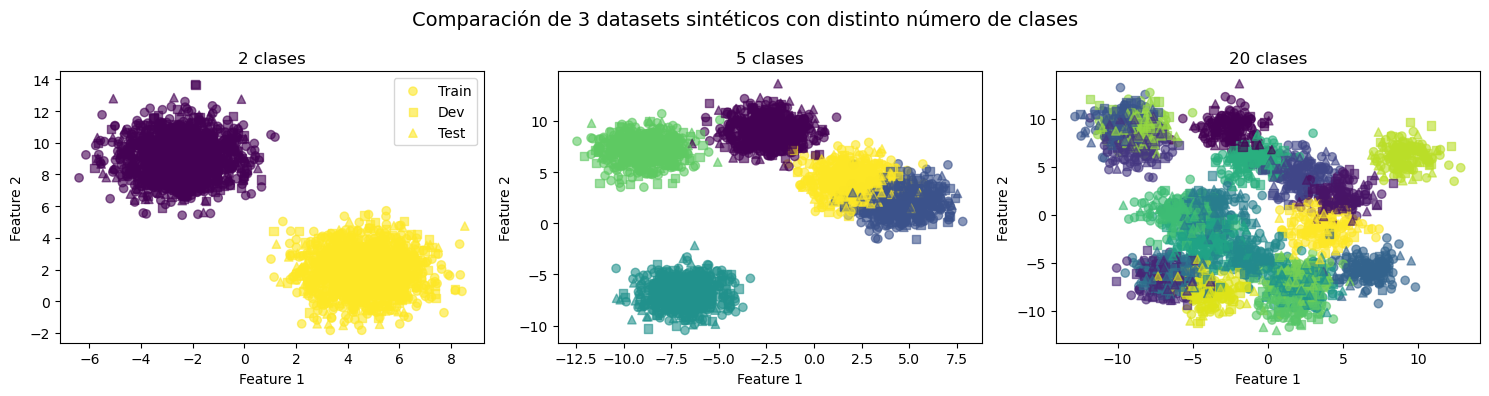

In [19]:
def split_and_plot(n_samples, centers, subplot_index):
    # 1. Generar dataset sintético con "centers" clases
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=1.2, random_state=42)

    # 2. Dividir en Train (60%) y resto (40%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )

    # 3. Dividir el resto en Dev (20%) y Test (20%)
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # 4. Visualización
    plt.subplot(1, 3, subplot_index)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="viridis", marker="o", alpha=0.6, label="Train")#alpha define transparencia en los puntos 
    plt.scatter(X_dev[:,0], X_dev[:,1], c=y_dev, cmap="viridis", marker="s", alpha=0.6, label="Dev")
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="viridis", marker="^", alpha=0.6, label="Test")
    plt.title(f"{centers} clases")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    if subplot_index == 1:  # Solo mostrar leyenda en el primer gráfico
        plt.legend()

plt.figure(figsize=(15, 4))

# Dataset A: 2 clases
split_and_plot(n_samples=3000, centers=2, subplot_index=1)

# Dataset B: 3 clases
split_and_plot(n_samples=3000, centers=5, subplot_index=2)

# Dataset C: 5 clases
split_and_plot(n_samples=3000, centers=20, subplot_index=3)

plt.suptitle("Comparación de 3 datasets sintéticos con distinto número de clases", fontsize=14)
plt.tight_layout()
plt.show()

### Selección del modelo

In [38]:
def generate_multiple_datasets(n_samples=3000, centers_list=[2,3,5], cluster_std=1.2, random_state=42):
    datasets = {}
    for centers in centers_list:
        X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_state)
        X_dev, X_test,  y_dev,  y_test  = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)
        datasets[centers] = {"X_train": X_train, "y_train": y_train,
                             "X_dev":   X_dev,   "y_dev":   y_dev,
                             "X_test":  X_test,  "y_test":  y_test}
    return datasets

In [40]:
# --- modelos a comparar (con escalado donde aplica) ---
def get_models():
    return {        
        "KNN":    Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=5))]),
        "SVM-RBF":Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf"))]),
        "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),                    
        "MLP":   Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))]),
    }

In [52]:
datasets = generate_multiple_datasets(n_samples=12000, centers_list=[2,5,20], cluster_std=1.2, random_state=42)
models = get_models()

rows = []
for k_classes, data in datasets.items():
    X_train, y_train = data["X_train"], data["y_train"]
    X_test,  y_test  = data["X_test"],  data["y_test"]
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")
        f1w = f1_score(y_test, y_pred, average="weighted")
        rows.append({"dataset_classes": k_classes, "model": name, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w})

results = pd.DataFrame(rows).sort_values(["dataset_classes","f1_macro"], ascending=[True, False])
print(results)

# Vista rápida por dataset (mejor f1_macro)
print("\nTop por dataset (f1_macro):")
print(results.loc[results.groupby("dataset_classes")["f1_macro"].idxmax(), ["dataset_classes","model","f1_macro","accuracy"]])

    dataset_classes         model  accuracy  f1_macro  f1_weighted
0                 2           KNN  1.000000  1.000000     1.000000
1                 2       SVM-RBF  1.000000  1.000000     1.000000
2                 2  DecisionTree  1.000000  1.000000     1.000000
3                 2           MLP  1.000000  1.000000     1.000000
7                 5           MLP  0.967917  0.967916     0.967916
5                 5       SVM-RBF  0.966667  0.966666     0.966666
4                 5           KNN  0.962500  0.962497     0.962497
6                 5  DecisionTree  0.947083  0.947178     0.947178
9                20       SVM-RBF  0.746250  0.742135     0.742135
11               20           MLP  0.744167  0.736420     0.736420
8                20           KNN  0.710000  0.708210     0.708210
10               20  DecisionTree  0.674167  0.636940     0.636940

Top por dataset (f1_macro):
   dataset_classes    model  f1_macro  accuracy
0                2      KNN  1.000000  1.000000
7   

#### Hiper-parámetros para KNN 

KNN, o K-Vecinos más Cercanos, es un algoritmo de aprendizaje supervisado que se puede usar tanto para clasificación como para regresión. En esencia, clasifica un nuevo punto de datos basándose en la mayoría de votos de sus 'k' vecinos más cercanos.

Ahora, para controlar cómo se comporta el algoritmo, se usan ciertos hiperparámetros

Los dos hiperparámetros más importantes en KNN son: el número de vecinos (k) y la métrica de distancia.

El parametro K Simplemente le dice al algoritmo cuántos vecinos cercanos debe mirar para tomar una decisión. 

Si k=1, solo se mira al vecino más cercano se adopta su identidad, si k=5, se miran sus 5 vecinos más cercanos y se toma la identidad que sea más común entre ellos (la mayoría de votos).

El valor de k tiene un gran impacto un k pequeño (como 1 o 3) hace que el modelo sea muy sensible a los datos locales. Puede capturar patrones complejos, pero también es muy vulnerable al ruido (puntos de datos aleatorios o erróneos).

Un k grande (como 15 o 21) hace que el modelo sea más general y estable, ya que considera más "opiniones". Sin embargo, si es demasiado grande, podría ignorar patrones locales importantes y simplificar demasiado el problema. Entonces, elegir el valor correcto de "k" es un acto de equilibrio.

La métrica de distancia es la "regla" que usa KNN para medir qué tan cerca o lejos están dos puntos de datos. Es como decidir si para ir a la a un punto a se va a medir la distancia en línea recta.

Las dos métricas de distancia más comunes son:

Distancia Euclidiana: Es la distancia en línea recta entre dos puntos. Es la más utilizada y funciona bien en la mayoría de los casos.

Distancia de Manhattan: También conocida como "distancia de la ciudad". Mide la distancia como si se moviera por una cuadrícula.

In [55]:
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],   # dejamos minkowski y movemos p
    "knn__p": [1, 2]                # 1=manhattan, 2=euclídea
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gcv = GridSearchCV(
    pipe_knn,
    param_grid=param_grid,
    scoring="f1_macro",   # o 'accuracy', 'f1_weighted' según tu objetivo
    cv=cv,
    n_jobs=-1
)
gcv.fit(X_train, y_train)

print("Mejores params:", gcv.best_params_)
print("Mejor score CV:", round(gcv.best_score_, 3))

# Evalúa en DEV o TEST (según tu protocolo)
from sklearn.metrics import classification_report
y_pred = gcv.predict(X_dev)  # o X_test
print(classification_report(y_dev, y_pred))

Mejores params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor score CV: 0.724
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       200
           1       0.81      0.83      0.82       200
           2       0.58      0.62      0.60       200
           3       0.65      0.68      0.66       200
           4       0.85      0.81      0.83       200
           5       0.57      0.61      0.59       200
           6       0.88      0.95      0.92       200
           7       0.52      0.40      0.45       200
           8       0.71      0.71      0.71       200
           9       0.83      0.81      0.82       200
          10       0.42      0.36      0.39       200
          11       0.79      0.80      0.79       200
          12       0.85      0.86      0.85       200
          13       0.73      0.78      0.76       200
          14       0.68      0.78      0.72       200
    

#### Hiper-parámetros para árbol de decisión 

Un Árbol de Decisión es como un diagrama de flujo donde cada "nodo" es una pregunta sobre los datos (por ejemplo, "¿la edad es mayor a 30?"). El objetivo es seguir un camino de preguntas hasta llegar a una "hoja" que nos da la predicción final.

Los hiperparámetros de un árbol ayudan a controlar qué tan grande y complejo se vuelve este diagrama de flujo. El objetivo principal es evitar que el árbol se aprenda los datos de entrenamiento de memoria, lo que se conoce como sobreajuste.

Entre los hiperparámetros tenemos el criterio el cual le dice al árbol cómo decidir cuál es la mejor pregunta para hacer en cada paso. 

El árbol quiere hacer preguntas que separen los datos de la forma más "pura" posible, dejando grupos donde la mayoría de los miembros sean de la misma clase.

Para medir esa "pureza", se tienen dos opciones principales:

Gini Impurity (Impureza de Gini): Mide la probabilidad de que si se elige un elemento al azar del grupo, lo clasifica incorrectamente. Un valor de 0 es perfecto (todos son de la misma clase).

Entropy (Entropía): Es un concepto de la teoría de la información que mide el desorden o la incertidumbre en un grupo. Al igual que con Gini, un valor de 0 significa que no hay desorden (todos son de la misma clase).

En la práctica, Gini y Entropía suelen dar resultados muy similares. Gini es un poco más rápido de calcular, por lo que a menudo es la opción por defecto.

El parametro de profundidad (depth) es como ponerle un límite al árbol. Le dice: "No puedes hacer más de 'X' preguntas en una fila para llegar a una conclusión".

Controla la longitud máxima de cualquier camino desde la raíz (la primera pregunta) hasta una hoja (la predicción final).

Un max_depth pequeño (por ejemplo, 2 o 3) crea un árbol muy simple y chaparro. Es fácil de entender, pero podría no ser lo suficientemente detallado para capturar toda la información de los datos. A esto se le llama subajuste (underfitting).

Un max_depth grande (o no ponerle límite) permite que el árbol crezca mucho, haciendo preguntas muy específicas hasta que cada dato de entrenamiento esté perfectamente clasificado.


El hiperparámetro min_samples_split establece el número mínimo de ejemplos que debe tener un nodo para que se le permita dividirse y seguir haciendo preguntas.

Si se establece min_samples_split=10, el árbol solo podrá hacer una nueva pregunta si el nodo actual tiene 10 o más ejemplos.

Si un nodo tiene 9 ejemplos, ya no podrá dividirse y se convertirá en una hoja (una respuesta final), incluso si su profundidad es menor que max_depth.

Este hiperparámetro es otra excelente herramienta para evitar el sobreajuste. Ayuda a impedir que el árbol se esfuerce en crear reglas súper específicas para grupos muy pequeños de datos.

In [56]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 7],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 20], #mínimo de muestras en cada hoja. Evita hojas diminutas (ruido).
    "max_features": [None, "sqrt", "log2"], #nº de variables candidatas por división. Limitarlo introduce regularización.
    "class_weight": [None, "balanced"],# "balanced" si hay desbalance de clases.
    "ccp_alpha": [0.0, 0.001, 0.01], # pruning cost–complexity (poda post-entrenamiento). >0 recorta ramas débiles.
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    # Base (por defecto)
    base = DecisionTreeClassifier(random_state=42)
    base.fit(Xtr, ytr)
    yhat_dv_base = base.predict(Xdv)
    base_acc = accuracy_score(ydv, yhat_dv_base)
    base_f1m = f1_score(ydv, yhat_dv_base, average="macro")
    base_f1w = f1_score(ydv, yhat_dv_base, average="weighted")

    # Optimizado (GridSearch en DEV)
    gcv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid, scoring="f1_macro",
                       cv=cv, n_jobs=-1, refit=True)
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    yhat_dv_best = best.predict(Xdv)
    best_acc = accuracy_score(ydv, yhat_dv_best)
    best_f1m = f1_score(ydv, yhat_dv_best, average="macro")
    best_f1w = f1_score(ydv, yhat_dv_best, average="weighted")

    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Default", "split": "DEV",
        "accuracy": base_acc, "f1_macro": base_f1m, "f1_weighted": base_f1w
    })
    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Optimized", "split": "DEV",
        "accuracy": best_acc, "f1_macro": best_f1m, "f1_weighted": best_f1w
    })

    # Guarda el mejor para test
    best_models[k_classes] = best

# Evaluación final en TEST con el optimizado
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted")
    })
    # (opcional) reporte detallado
    # print(f"\n=== TEST {k_classes} clases ===")
    # print(classification_report(yte, yhat_te))

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida: ganador en DEV por dataset
print("\nTop DEV por dataset:")
print(results[results["split"]=="DEV"].loc[results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
      ["dataset_classes","model","accuracy","f1_macro"]])

   dataset_classes         model split  accuracy  f1_macro  f1_weighted
0                2    DT-Default   DEV  1.000000  1.000000     1.000000
1                2  DT-Optimized   DEV  1.000000  1.000000     1.000000
6                2  DT-Optimized  TEST  1.000000  1.000000     1.000000
3                5  DT-Optimized   DEV  0.961250  0.961143     0.961143
2                5    DT-Default   DEV  0.946250  0.946140     0.946140
7                5  DT-Optimized  TEST  0.960000  0.959983     0.959983
5               20  DT-Optimized   DEV  0.720417  0.717556     0.717556
4               20    DT-Default   DEV  0.662083  0.661658     0.661658
8               20  DT-Optimized  TEST  0.727083  0.725107     0.725107

Top DEV por dataset:
   dataset_classes         model  accuracy  f1_macro
0                2    DT-Default  1.000000  1.000000
3                5  DT-Optimized  0.961250  0.961143
5               20  DT-Optimized  0.720417  0.717556


Se tienen datasets (2, 5 y 20 clases) donde se quere comparar un árbol simple por defecto vs. un árbol optimizado con GridSearchCV.

Se evalúan ambos en el conjunto de desarrollo (DEV). Luego se usa el mejor modelo optimizado para evaluar en TEST. Esto simula un flujo real: entrenar , validar , seleccionar , testear.

**GridSearchCV:** prueba varias combinaciones de: 

- Criterio de impureza: gini vs entropía.
- Profundidad máxima (max_depth): hasta 7 niveles o ilimitado (None).
- Tamaño mínimo de división/hoja: regularizan contra el sobreajuste.
- max_features: cuántas variables usar al dividir.
- class_weight: útil si hay desbalance.
- ccp_alpha: poda post-entrenamiento.

Esto permite encontrar un árbol menos sobreajustado y más generalizable.

**Interpretación esperada**

- DT-Default (DEV): suele sobreajustar, especialmente si el dataset tiene ruido o varias clases.
- DT-Optimized (DEV): debería mejorar F1 macro (porque los hiperparámetros limitan sobreajuste).
- DT-Optimized (TEST): este es el resultado final que realmente importa: qué tan bien generaliza.































#### Hiper-parámetros para SVM

La idea principal de un SVM es encontrar la "calle" o el "margen" más ancho posible que separe perfectamente dos clases de datos. Los puntos que están justo en el borde de esta calle se llaman vectores de soporte, y son los que definen dónde se dibuja la línea de separación.

Los hiperparámetros nos ayudan a definir cómo de ancha y flexible puede ser esta calle, y qué hacer si algunos puntos se "meten" en ella.

Los más importantes son C: El parámetro de regularización, el kernel: El tipo de "calle" o frontera que vamos a dibujar, y  gamma: La influencia que tiene cada punto de entrenamiento.

Son todos importantes, pero C y kernel son los que definen el comportamiento fundamental del modelo.

El parámetro C es fundamental porque controla el balance entre el error y la simplicidad del modelo. 

Un C alto penaliza mucho los errores. El modelo se esfuerza por clasificar cada punto de entrenamiento correctamente, lo que puede llevar a un sobreajuste, por otro lado un C bajo Es más tolerante con los errores. Busca un margen más amplio y un modelo más general, lo que puede ser mejor para datos nuevos, aunque no sea perfecto con los de entrenamiento.


El kernel es una función matemática que nos permite crear fronteras de decisión mucho más complejas y flexibles.

si no es posible separar los datos en su dimensión actual, el kernel los proyecta a una dimensión superior donde sí se puedan separar con una línea (o un plano).

Por ejemplo si se tienen puntos azules y rojos mezclados en una hoja de papel (2D). El "truco" sería como lanzar la hoja al aire de tal forma que todos los puntos azules queden por arriba y los rojos por abajo. 




In [57]:
# --- SVM con scaling y GridSearch ---
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=False))  # para velocidad; si quieres ROC, usa True
])

param_grid = [
    {"svm__kernel": ["linear"], "svm__C": [0.1, 1, 10, 100]},#frontera recta, útil si las clases son linealmente separables.
    {"svm__kernel": ["rbf"],    "svm__C": [0.1, 1, 10, 100], "svm__gamma": ["scale", 0.1, 0.01, 0.001]},# frontera flexible, buena para problemas no lineales.
    # opcional: polinomial (suele ser más lento)
    # {"svm__kernel": ["poly"], "svm__degree":[2,3], "svm__C":[0.1,1,10], "svm__gamma":["scale", 0.1]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    gcv = GridSearchCV(
        estimator=pipe_svm,
        param_grid=param_grid,
        scoring="f1_macro",   # multiclase: trata las clases por igual
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    best_models[k_classes] = best

    # Evaluación en DEV
    yhat_dv = best.predict(Xdv)
    rows.append({
        "dataset_classes": k_classes, "model": "SVM-Optimized", "split": "DEV",
        "accuracy": accuracy_score(ydv, yhat_dv),
        "f1_macro": f1_score(ydv, yhat_dv, average="macro"),
        "f1_weighted": f1_score(ydv, yhat_dv, average="weighted"),
        "best_params": gcv.best_params_
    })

# Evaluación final en TEST
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes, "model": "SVM-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted"),
        "best_params": best.get_params()
    })

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida: mejor SVM (DEV) por dataset y su rendimiento en TEST
print("\nTop DEV por dataset (SVM):")
print(results[results["split"]=="DEV"].loc[
    results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
    ["dataset_classes","model","f1_macro","accuracy","best_params"]
])
print("\nResultados TEST (SVM optimizado):")
print(results[results["split"]=="TEST"].sort_values(["dataset_classes","f1_macro"], ascending=[True, False]))

   dataset_classes          model split  accuracy  f1_macro  f1_weighted  \
0                2  SVM-Optimized   DEV  1.000000  1.000000     1.000000   
3                2  SVM-Optimized  TEST  1.000000  1.000000     1.000000   
1                5  SVM-Optimized   DEV  0.968750  0.968720     0.968720   
4                5  SVM-Optimized  TEST  0.966667  0.966665     0.966665   
2               20  SVM-Optimized   DEV  0.752083  0.749915     0.749915   
5               20  SVM-Optimized  TEST  0.749167  0.746107     0.746107   

                                         best_params  
0           {'svm__C': 0.1, 'svm__kernel': 'linear'}  
3  {'memory': None, 'steps': [('scaler', Standard...  
1  {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern...  
4  {'memory': None, 'steps': [('scaler', Standard...  
2  {'svm__C': 100, 'svm__gamma': 0.001, 'svm__ker...  
5  {'memory': None, 'steps': [('scaler', Standard...  

Top DEV por dataset (SVM):
   dataset_classes          model  f1_macro  accuracy 

Primero se entrena y busca hiperparámetros con train, Luego se evalúa el mejor modelo en DEV (validación), Finalmente se reentrena y se evalúa en TEST.

Métricas:

Accuracy: porcentaje de aciertos.

F1-macro: equilibrio entre precisión y recall en cada clase, promediado de forma igualitaria.

F1-weighted: como macro, pero ponderado por el número de ejemplos de cada clase.

En 2 clases, SVM lineal debería bastar (problema fácil).

En 5 clases, probablemente RBF dé mejor resultado si hay solapamiento.

En 20 clases, el problema es más complejo → RBF con ajuste fino de C y gamma suele rendir mejor.

f1_macro es la métrica clave: si se mantiene alto en 20 clases, significa que el modelo no descuida clases minoritarias.

#### Hiper-parámetros para MLP

Un Perceptrón Multicapa o MLP (Multi-Layer Perceptron) es básicamente un conjunto de "neuronas" organizadas en capas. Los datos entran por la primera capa, pasan por una o más capas ocultas donde ocurre la "magia" del aprendizaje, y finalmente salen por la última capa con una predicción.

Los hiperparámetros de un MLP nos ayudan a definir la arquitectura de esta red y cómo aprende. 

arquitectura de las capas ocultas: Este es probablemente el aspecto más "creativo" de diseñar un MLP. Se refiere a dos decisiones clave:

Número de capas ocultas: ¿Cuántas capas de neuronas habrá entre la entrada y la salida?

Número de neuronas por capa: ¿Qué tan "ancha" será cada una de estas capas?

Sabiendo que una red más grande puede memorizar pero una más pequeña podría no aprender lo suficiente.

Este parámetro funciona por "prueba y error", es la forma más común de encontrar la arquitectura ideal. En el mundo del machine learning, a este proceso estructurado de prueba y error se le suelen llamar búsqueda de hiperparámetros (hyperparameter tuning). 

No hay una fórmula mágica, así que los expertos prueban muchas combinaciones diferentes para ver cuál funciona mejor.

 la función de activación: es una pieza clave. Si las neuronas son los "ladrillos" de la red, la función de activación es lo que decide si un ladrillo se "enciende" y contribuye a la construcción o no.

Después de que una neurona suma todas las señales que le llegan de la capa anterior, pasa el resultado a través de una función de activación. Esta función transforma el número y decide qué tan importante es esa señal para pasarla a la siguiente capa.

Sin estas funciones, una red neuronal, sin importar cuántas capas tenga, se comportaría como un simple modelo lineal. Las funciones de activación introducen la no linealidad que permite a la red aprender patrones increíblemente complejos.

In [58]:
# MLP necesita escalado
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=500, random_state=42))
])

# Hiperparámetros a explorar
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (100,50)],# estructura de la red (nº de neuronas por capa).
    "mlp__activation": ["relu", "tanh"],# función de activación.
    "mlp__alpha": [0.0001, 0.001, 0.01],   # regularización L2 (para evitar sobreajuste).
    "mlp__learning_rate_init": [0.001, 0.01],  # tasa de aprendizaje (para Adam o SGD).
    "mlp__solver": ["adam"]   # dejamos Adam por practicidad optimizador.
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    gcv = GridSearchCV(
        pipe_mlp, param_grid=param_grid,
        scoring="f1_macro", cv=cv, n_jobs=-1, refit=True, verbose=0
    )
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    best_models[k_classes] = best

    # Evaluación en DEV
    yhat_dv = best.predict(Xdv)
    rows.append({
        "dataset_classes": k_classes, "model": "MLP-Optimized", "split": "DEV",
        "accuracy": accuracy_score(ydv, yhat_dv),
        "f1_macro": f1_score(ydv, yhat_dv, average="macro"),
        "f1_weighted": f1_score(ydv, yhat_dv, average="weighted"),
        "best_params": gcv.best_params_
    })

# Evaluación en TEST
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes, "model": "MLP-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted"),
        "best_params": best.get_params()["mlp"]
    })

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida
print("\nTop DEV por dataset (MLP):")
print(results[results["split"]=="DEV"].loc[
    results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
    ["dataset_classes","model","f1_macro","accuracy","best_params"]
])
print("\nResultados TEST (MLP optimizado):")
print(results[results["split"]=="TEST"].sort_values(["dataset_classes","f1_macro"], ascending=[True, False]))

   dataset_classes          model split  accuracy  f1_macro  f1_weighted  \
0                2  MLP-Optimized   DEV  1.000000  1.000000     1.000000   
3                2  MLP-Optimized  TEST  1.000000  1.000000     1.000000   
1                5  MLP-Optimized   DEV  0.969583  0.969553     0.969553   
4                5  MLP-Optimized  TEST  0.966667  0.966630     0.966630   
2               20  MLP-Optimized   DEV  0.741667  0.735093     0.735093   
5               20  MLP-Optimized  TEST  0.739583  0.732222     0.732222   

                                         best_params  
0  {'mlp__activation': 'relu', 'mlp__alpha': 0.00...  
3  MLPClassifier(hidden_layer_sizes=(50,), max_it...  
1  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01...  
4  MLPClassifier(activation='tanh', alpha=0.01, h...  
2  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01...  
5  MLPClassifier(activation='tanh', alpha=0.01, h...  

Top DEV por dataset (MLP):
   dataset_classes          model  f1_macro  accuracy 

In [69]:
# 3. Evaluación
rows = []
conf_matrices = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xte, yte = d["X_test"],  d["y_test"]

    for nombre, modelo in modelos.items():
        modelo.fit(Xtr, ytr)
        ypred = modelo.predict(Xte)

        acc = accuracy_score(yte, ypred)
        prec = precision_score(yte, ypred, average="macro")
        rec = recall_score(yte, ypred, average="macro")
        f1m = f1_score(yte, ypred, average="macro")
        f1w = f1_score(yte, ypred, average="weighted")

        rows.append({
            "dataset_classes": k_classes,
            "model": nombre,
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        # Guardamos la matriz de confusión
        conf_matrices[(k_classes, nombre)] = confusion_matrix(yte, ypred)

# 4. Resultados en tabla
results = pd.DataFrame(rows).sort_values(["dataset_classes","f1_macro"], ascending=[True, False])
print(results)

# 5. Ejemplo: mostrar matrices de confusión de cada modelo en 3 clases
print("\nMATRICES DE CONFUSIÓN (dataset 3 clases):")
for nombre in modelos.keys():
    print(f"\nModelo: {nombre}")
    print(conf_matrices[(20, nombre)])

/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


    dataset_classes         model  accuracy  precision_macro  recall_macro  \
0                 2           KNN  1.000000         1.000000      1.000000   
1                 2  DecisionTree  1.000000         1.000000      1.000000   
2                 2       SVM-RBF  1.000000         1.000000      1.000000   
3                 2           MLP  1.000000         1.000000      1.000000   
6                 5       SVM-RBF  0.969167         0.969221      0.969167   
7                 5           MLP  0.968750         0.968775      0.968750   
4                 5           KNN  0.962500         0.962515      0.962500   
5                 5  DecisionTree  0.947083         0.947430      0.947083   
10               20       SVM-RBF  0.746250         0.743631      0.746250   
11               20           MLP  0.741667         0.737933      0.741667   
8                20           KNN  0.710000         0.709573      0.710000   
9                20  DecisionTree  0.674167         0.645540    

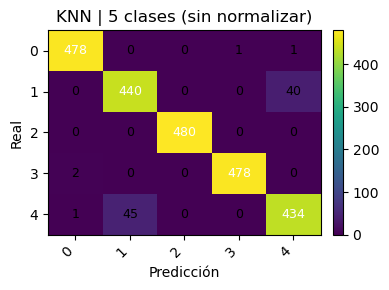

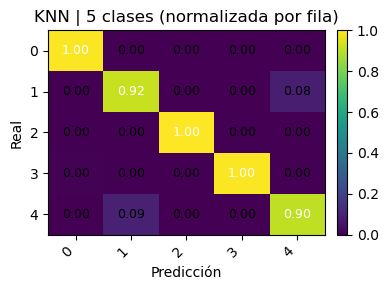

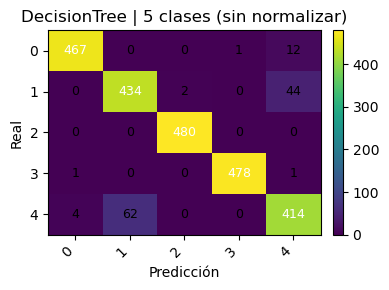

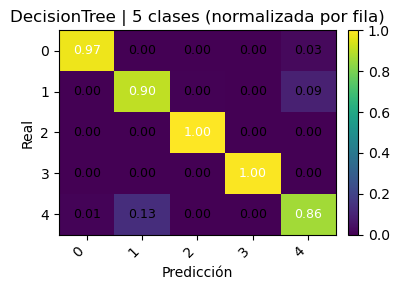

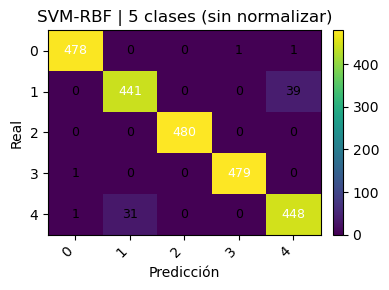

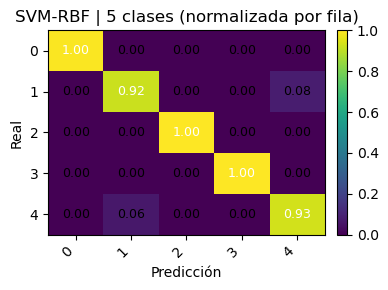

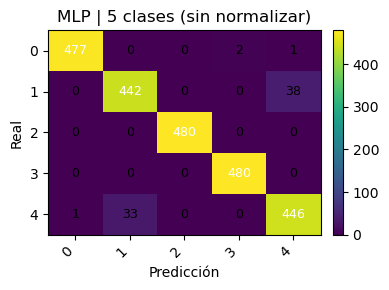

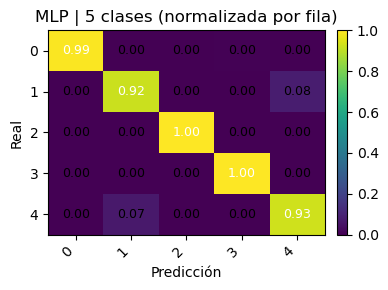

In [74]:
def plot_confusion_heatmap(cm, class_names, title="Matriz de confusión", normalize=False):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    # anotaciones
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}",
                    ha="center", va="center", fontsize=9, color="white" if im.norm(cm[i,j])>0.5 else "black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Ejemplo: mostrar heatmaps para TODOS los modelos del dataset de 3 clases
k = 5
class_names = sorted(np.unique(datasets[k]["y_test"]))
for model_name in modelos.keys():
    cm = conf_matrices[(k, model_name)]
    plot_confusion_heatmap(cm, class_names, title=f"{model_name} | {k} clases (sin normalizar)", normalize=False)
    plot_confusion_heatmap(cm, class_names, title=f"{model_name} | {k} clases (normalizada por fila)", normalize=True)

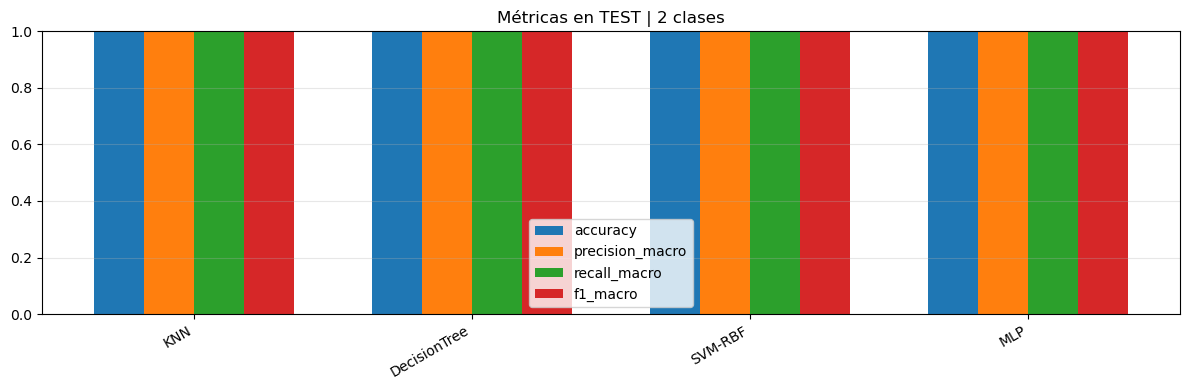

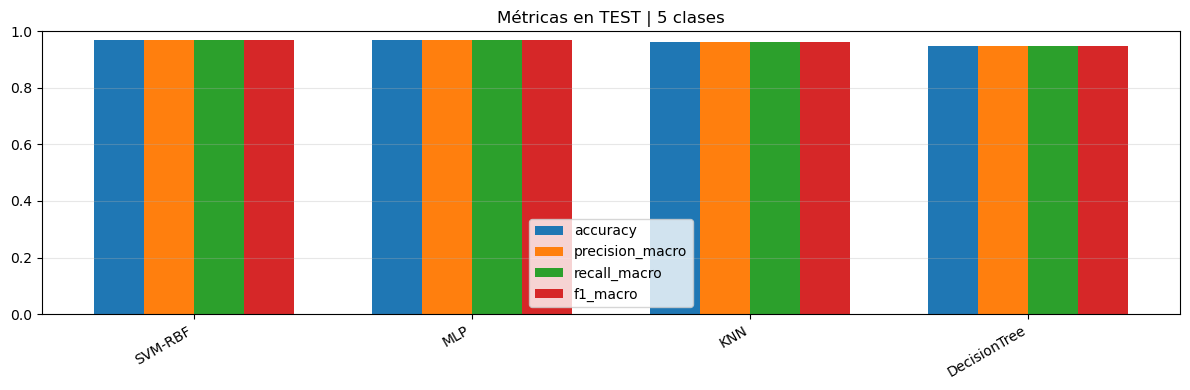

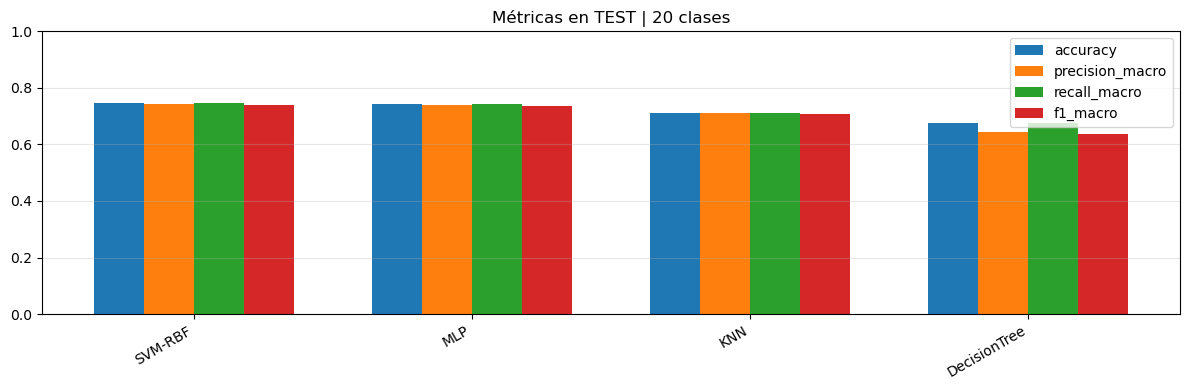

In [75]:
def barplot_metrics(results, k_classes, metrics=("accuracy","precision_macro","recall_macro","f1_macro")):
    df = results[results["dataset_classes"]==k_classes].copy()
    # si tienes filas DEV y TEST, filtra una (ej. TEST) para comparar final
    if "split" in df.columns:
        df = df[df["split"]=="TEST"].copy()
    models = df["model"].tolist()
    x = np.arange(len(models))
    width = 0.18

    fig, ax = plt.subplots(figsize=(12,4))
    for i, m in enumerate(metrics):
        ax.bar(x + i*width, df[m].values, width, label=m)
    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=30, ha="right")
    ax.set_ylim(0, 1.0)
    ax.set_title(f"Métricas en TEST | {k_classes} clases")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Barras para 2, 3 y 5 clases (puedes cambiar el set de métricas si quieres)
for k in [2,5,20]:
    barplot_metrics(results, k, metrics=("accuracy","precision_macro","recall_macro","f1_macro"))

In [76]:
def plot_decision_boundary(ax, clf, X, y, title=None, proba=False, padding=0.05, grid=300):
    # Rango con pequeño padding
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    dx, dy = x_max - x_min, y_max - y_min
    x_min, x_max = x_min - dx*padding, x_max + dx*padding
    y_min, y_max = y_min - dy*padding, y_max + dy*padding

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid),
                         np.linspace(y_min, y_max, grid))
    grid_xy = np.c_[xx.ravel(), yy.ravel()]

    # Predicción en rejilla
    if proba and hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(grid_xy).argmax(1)  # clase más probable
    else:
        Z = clf.predict(grid_xy)
    Z = Z.reshape(xx.shape)

    # Mapa de decisión + puntos
    cs = ax.contourf(xx, yy, Z, alpha=0.25, levels=np.unique(Z).size)
    sc = ax.scatter(X[:,0], X[:,1], c=y, s=20, alpha=0.8)
    ax.set_title(title or type(clf).__name__)
    ax.set_xlabel("Feature 1"); ax.set_ylabel("Feature 2")

def visualize_many_classifiers(classifiers, X, y, cols=3, fit=True):
    """
    classifiers: lista de (nombre, estimator) — usa Pipeline con StandardScaler si el modelo lo necesita.
    X, y: datos 2D (si tienes >2 features, proyecta antes con PCA/UMAP).
    """
    n = len(classifiers)
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
    axes = np.array(axes).reshape(-1)

    for i, (name, clf) in enumerate(classifiers):
        if fit:
            clf.fit(X, y)
        plot_decision_boundary(axes[i], clf, X, y, title=name)
    # ocultar subplots vacíos
    for j in range(i+1, rows*cols):
        axes[j].axis("off")
    plt.tight_layout(); plt.show()

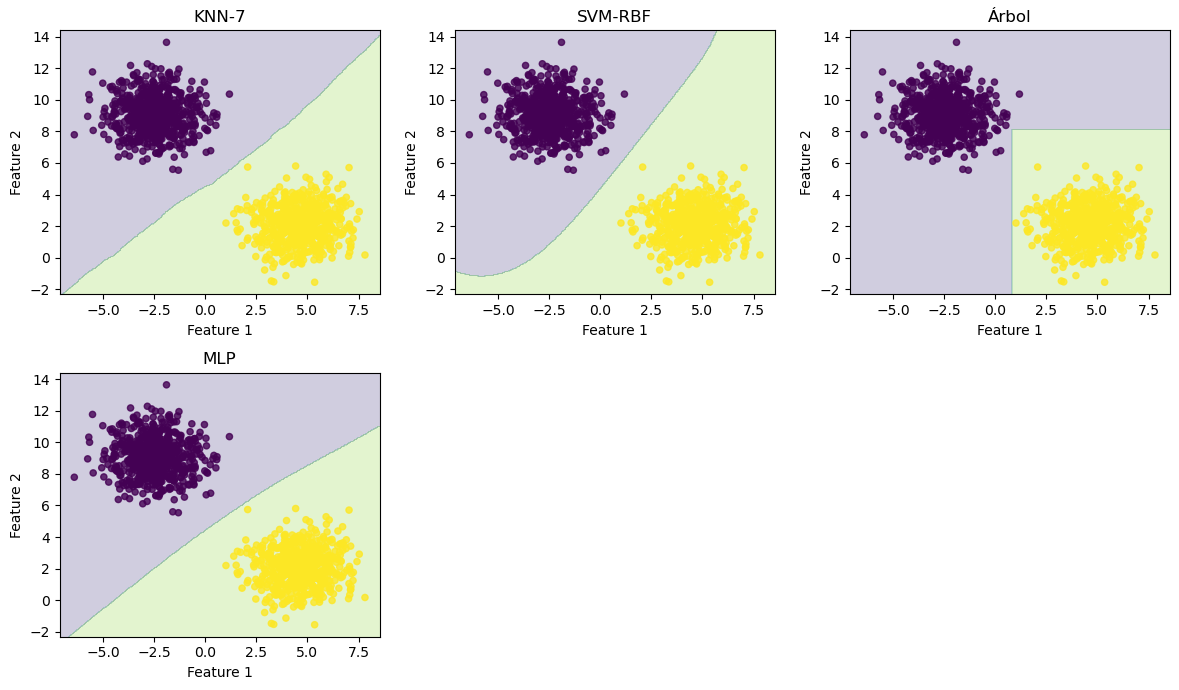

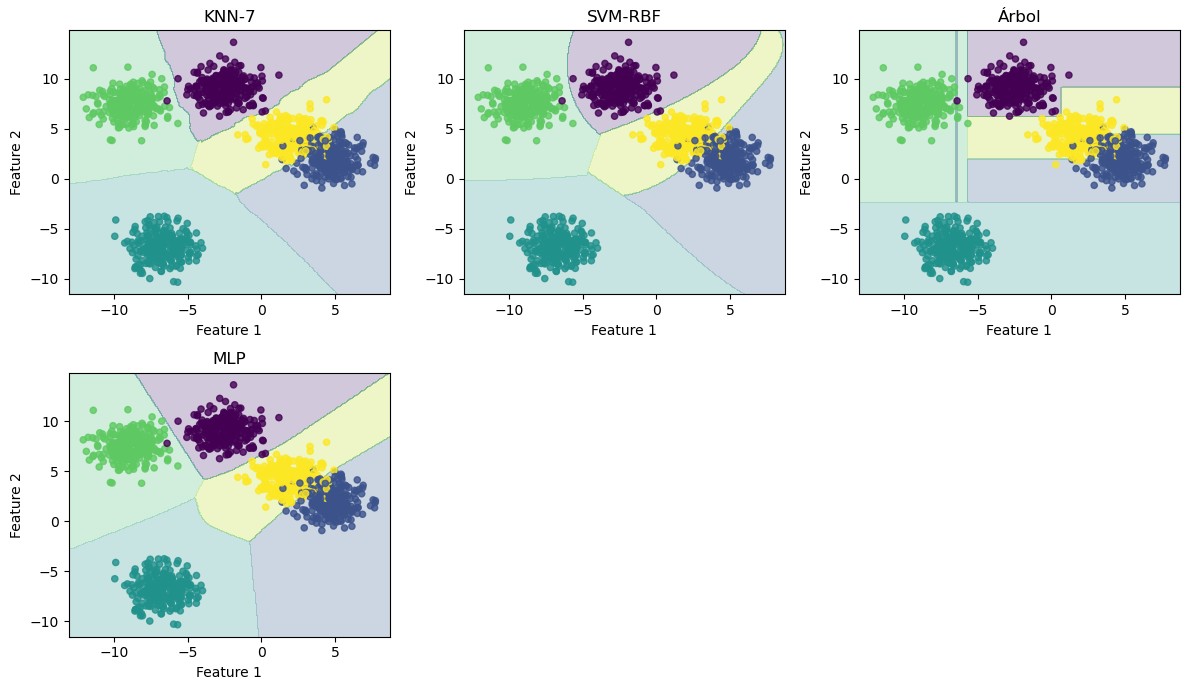

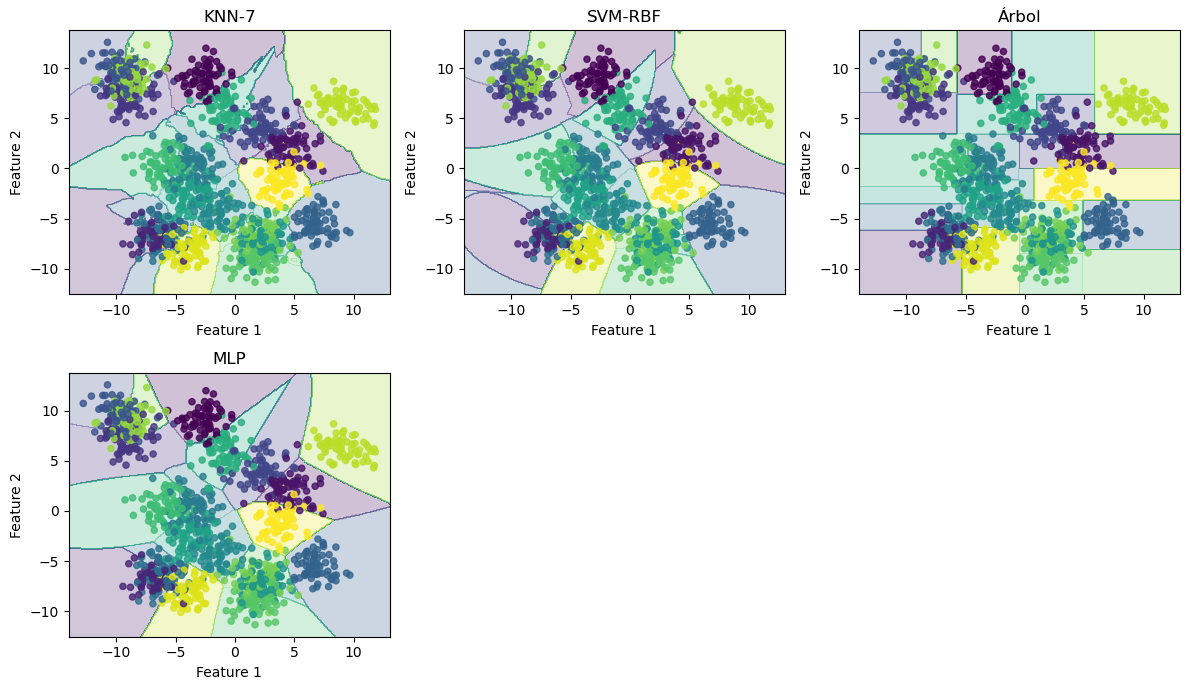

In [80]:
# Datos 2D
X_a, y_a = make_blobs(n_samples=1249, centers=2, cluster_std=1.2, random_state=42)
X_b, y_b = make_blobs(n_samples=1249, centers=5, cluster_std=1.2, random_state=42)
X_c, y_c = make_blobs(n_samples=1249, centers=20, cluster_std=1.2, random_state=42)

clfs = [
    
    ("KNN-7",  Pipeline([("sc", StandardScaler()),
                         ("clf", KNeighborsClassifier(n_neighbors=7))])),
    
    ("SVM-RBF",Pipeline([("sc", StandardScaler()),
                         ("clf", SVC(kernel="rbf", C=10, gamma="scale"))])),
    
    ("Árbol",  DecisionTreeClassifier(max_depth=5, random_state=42)),
    
    ("MLP",    Pipeline([("sc", StandardScaler()),
                         ("clf", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))])),
]

visualize_many_classifiers(clfs, X_a, y_a, cols=3, fit=True)
visualize_many_classifiers(clfs, X_b, y_b, cols=3, fit=True)
visualize_many_classifiers(clfs, X_c, y_c, cols=3, fit=True)

Los resultados de las métricas bajan al aumentar el número de clases esto quiere decir una mayor complejidad del espacio de decisión, con 2 clases, el modelo solo necesita una frontera clara, con 20 clases, debe aprender 19 fronteras simultáneas por clase, esto aumenta la probabilidad de confusión entre clases cercanas.

Si el dataset tiene un tamaño fijo (ej. 12000 muestras), al dividir en 20 clases, cada una tiene pocas instancias, con menos datos por clase, el modelo tiene menos ejemplos para aprender, por otro lado, en multiclase, es común que algunas clases queden con menos ejemplos, esto afecta precision y recall.


# Escenario 2: Big Data vs. Small Data

En este escenario se busca analizar cómo influye la cantidad de datos disponibles en el desempeño de distintos modelos de clasificación supervisada. Para ello, se generan conjuntos de datos sintéticos utilizando la función `make_gaussian_quantiles` de *scikit-learn*, con cuatro clases y diferentes tamaños de muestra: \(10^2\), \(10^3\), \(10^4\), \(10^5\) y \(10^6\).

Los datos en cada caso se dividen en subconjuntos de entrenamiento, validación (desarrollo) y prueba. A continuación, se entrenan y ajustan diferentes clasificadores representativos —*k-Nearest Neighbors (k-NN)*, *Decision Tree*, *Support Vector Machine (SVM)* y *Multi-Layer Perceptron (MLP)*— aplicando búsqueda de hiperparámetros con `GridSearchCV` para seleccionar la mejor configuración en cada tamaño de dataset.

Finalmente, se comparan los resultados obtenidos en el conjunto de prueba utilizando métricas como **accuracy** y **F1-score macro**, y se emplean diferentes técnicas de visualización (bar plots, heatmaps, radar plots) para ilustrar las tendencias observadas. De esta manera, se podrá discutir qué modelos escalan mejor con grandes volúmenes de datos y cuáles son más adecuados en escenarios con disponibilidad limitada de muestras.


### Configuración inicial

In [2]:
warnings.filterwarnings("ignore")
RND = 42

RUN_SIZES = [10**2, 10**3, 10**4, 10**5]
USE_1M = True
if USE_1M and 10**6 not in RUN_SIZES:
    RUN_SIZES.append(10**6)

# Maxímo de filas para usar modelos pesados (SVM-RBF, KNN, MLP)
MAX_ROWS_FOR_HEAVY_MODELS = 200_000 # sustitución por modelos lineale


### Generación de conjuntos de datos

In [3]:
def gen_and_split(n_samples, n_features=2, n_classes=4, random_state=RND):
    X, y = make_gaussian_quantiles(n_samples=n_samples, n_features=n_features,
                                   n_classes=n_classes, random_state=random_state)
    # split 60/20/20 train/dev/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_state)
    X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    return X_train, X_dev, X_test, y_train, y_dev, y_test


### Definición de modelos

In [4]:
# Para datasets pequeños/medianos usamos los 4 modelos completos (kNN, DecisionTree, SVM, MLP).
base_models = {
    "kNN": (KNeighborsClassifier(), {"n_neighbors":[3,5,7]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=RND), {"max_depth":[3,5,10,None], "min_samples_leaf":[1,2,5]}),
    "SVM": (SVC(), {"C":[0.1,1], "kernel":["linear","rbf"]}),
    "MLP": (MLPClassifier(max_iter=300, random_state=RND), {"hidden_layer_sizes":[(50,),(100,)], "learning_rate_init":[0.001]})
}

# Para datasets muy grandes (>= 10^6), sustituimos SVM/MLP por SGDClassifier, ya que es más eficiente computacionalmente y escala mejor a millones de muestras.
large_models = {
    "kNN": (KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1), {"n_neighbors":[3,5]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=RND), {"max_depth":[10, None], "min_samples_leaf":[1,5]}),
    "SGD_log": (SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=RND), {"alpha":[1e-4,1e-3]}),  # proxy para SVM/LogReg
}


### Función de experimentación

In [5]:
def run_experiment(sizes, use_large_subs=True, random_state=RND):
    results = []
    details = []
    for n in sizes:
        print(f"\n--- Size: {n} samples ---")
        X_train, X_dev, X_test, y_train, y_dev, y_test = gen_and_split(n)
        n_train = X_train.shape[0]
        print(f"Train/dev/test sizes: {X_train.shape[0]}/{X_dev.shape[0]}/{X_test.shape[0]}")
        
        # Decide los modelos
        if use_large_subs and n > MAX_ROWS_FOR_HEAVY_MODELS:
            models = large_models
            print("Usando configuración para datasets grandes (modelos ligeros).")
        else:
            models = base_models
        
        for name, (model, grid) in models.items():
            print(f" -> Model: {name}")
            # GridSearch sobre X_train
            grid_search = GridSearchCV(model, grid, cv=3, scoring='accuracy', n_jobs=-1, refit=True)
            try:
                grid_search.fit(X_train, y_train)
                best = grid_search.best_estimator_
            except Exception as e:
                print(f"   ERROR al entrenar {name}: {e}. Intentando fit directo con parámetros por defecto.")
                try:
                    model.fit(X_train, y_train)
                    best = model
                except Exception as e2:
                    print(f"   Falló también fit directo: {e2}. Se salta este modelo.")
                    continue

            # Evaluación
            y_dev_pred = best.predict(X_dev)
            y_test_pred = best.predict(X_test)
            acc_dev = accuracy_score(y_dev, y_dev_pred)
            acc_test = accuracy_score(y_test, y_test_pred)
            f1_dev = f1_score(y_dev, y_dev_pred, average='macro')
            f1_test = f1_score(y_test, y_test_pred, average='macro')

            results.append({
                "n_samples": n,
                "model": name,
                "best_params": getattr(grid_search, "best_params_", None),
                "acc_dev": acc_dev,
                "acc_test": acc_test,
                "f1_dev": f1_dev,
                "f1_test": f1_test,
                "n_train": n_train
            })
            # Guardar reportes detallados
            details.append({
                "n_samples": n,
                "model": name,
                "classification_report_test": classification_report(y_test, y_test_pred, zero_division=0),
                "confusion_matrix_test": confusion_matrix(y_test, y_test_pred)
            })
            print(f"    acc_dev={acc_dev:.4f}  acc_test={acc_test:.4f}  f1_test={f1_test:.4f}")

    df = pd.DataFrame(results)
    return df, details


### Ejecución y guardado de resultados

In [6]:
df_results, details = run_experiment(RUN_SIZES, use_large_subs=True)
print("\n== Resultados resumidos ==")
display(df_results)

# Guardado de resultados
df_results, details = run_experiment(RUN_SIZES, use_large_subs=True)


--- Size: 100 samples ---
Train/dev/test sizes: 60/20/20
 -> Model: kNN
    acc_dev=0.6000  acc_test=0.6000  f1_test=0.5951
 -> Model: DecisionTree
    acc_dev=0.5500  acc_test=0.6000  f1_test=0.6154
 -> Model: SVM
    acc_dev=0.6000  acc_test=0.4000  f1_test=0.3955
 -> Model: MLP
    acc_dev=0.6000  acc_test=0.3500  f1_test=0.3523

--- Size: 1000 samples ---
Train/dev/test sizes: 600/200/200
 -> Model: kNN
    acc_dev=0.8950  acc_test=0.9100  f1_test=0.9090
 -> Model: DecisionTree
    acc_dev=0.8750  acc_test=0.8950  f1_test=0.8895
 -> Model: SVM
    acc_dev=0.9200  acc_test=0.9300  f1_test=0.9291
 -> Model: MLP
    acc_dev=0.9250  acc_test=0.9300  f1_test=0.9283

--- Size: 10000 samples ---
Train/dev/test sizes: 6000/2000/2000
 -> Model: kNN
    acc_dev=0.9760  acc_test=0.9740  f1_test=0.9741
 -> Model: DecisionTree
    acc_dev=0.9620  acc_test=0.9605  f1_test=0.9607
 -> Model: SVM
    acc_dev=0.9830  acc_test=0.9870  f1_test=0.9870
 -> Model: MLP
    acc_dev=0.9885  acc_test=0.9905

,n_samples,model,best_params,acc_dev,acc_test,f1_dev,f1_test,n_train
0,100,kNN,{'n_neighbors': 3},0.600000,0.600000,0.621337,0.595130,60
1,100,DecisionTree,"{'max_depth': 5, 'min_samples_leaf': 1}",0.550000,0.600000,0.541667,0.615385,60
2,100,SVM,"{'C': 1, 'kernel': 'rbf'}",0.600000,0.400000,0.600866,0.395455,60
3,100,MLP,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.600000,0.350000,0.600866,0.352273,60
4,1000,kNN,{'n_neighbors': 5},0.895000,0.910000,0.889057,0.908963,600
5,1000,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1}",0.875000,0.895000,0.871148,0.889464,600
6,1000,SVM,"{'C': 1, 'kernel': 'rbf'}",0.920000,0.930000,0.916799,0.929127,600
7,1000,MLP,"{'hidden_layer_sizes': (100,), 'learning_rate_...",0.925000,0.930000,0.922293,0.928287,600
8,10000,kNN,{'n_neighbors': 3},0.976000,0.974000,0.975888,0.974088,6000
9,10000,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1}",0.962000,0.960500,0.961770,0.960671,6000



--- Size: 100 samples ---
Train/dev/test sizes: 60/20/20
 -> Model: kNN
    acc_dev=0.6000  acc_test=0.6000  f1_test=0.5951
 -> Model: DecisionTree
    acc_dev=0.5500  acc_test=0.6000  f1_test=0.6154
 -> Model: SVM
    acc_dev=0.6000  acc_test=0.4000  f1_test=0.3955
 -> Model: MLP
    acc_dev=0.6000  acc_test=0.3500  f1_test=0.3523

--- Size: 1000 samples ---
Train/dev/test sizes: 600/200/200
 -> Model: kNN
    acc_dev=0.8950  acc_test=0.9100  f1_test=0.9090
 -> Model: DecisionTree
    acc_dev=0.8750  acc_test=0.8950  f1_test=0.8895
 -> Model: SVM
    acc_dev=0.9200  acc_test=0.9300  f1_test=0.9291
 -> Model: MLP
    acc_dev=0.9250  acc_test=0.9300  f1_test=0.9283

--- Size: 10000 samples ---
Train/dev/test sizes: 6000/2000/2000
 -> Model: kNN
    acc_dev=0.9760  acc_test=0.9740  f1_test=0.9741
 -> Model: DecisionTree
    acc_dev=0.9620  acc_test=0.9605  f1_test=0.9607
 -> Model: SVM
    acc_dev=0.9830  acc_test=0.9870  f1_test=0.9870
 -> Model: MLP
    acc_dev=0.9885  acc_test=0.9905

### Visualización

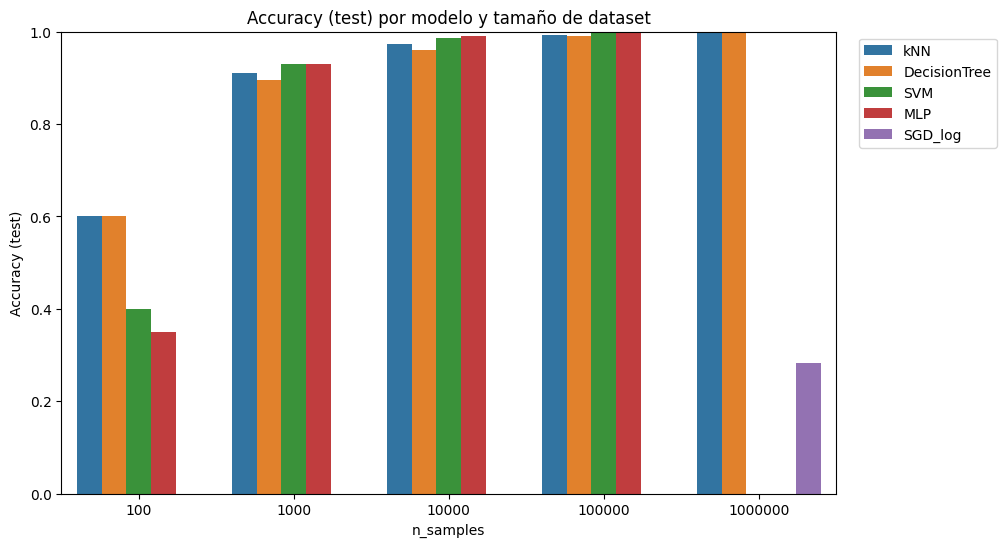

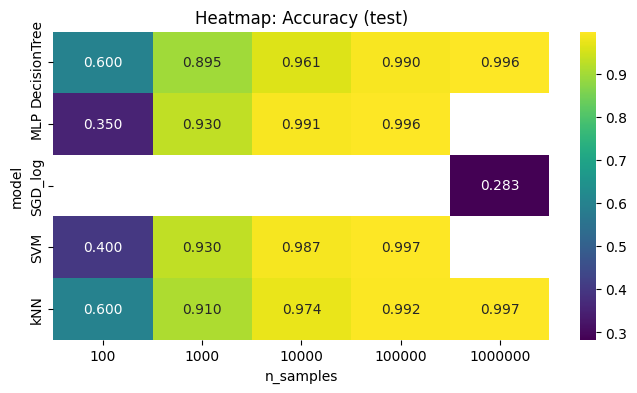

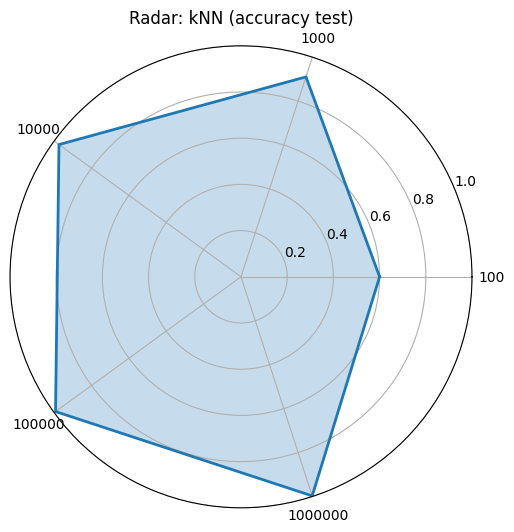

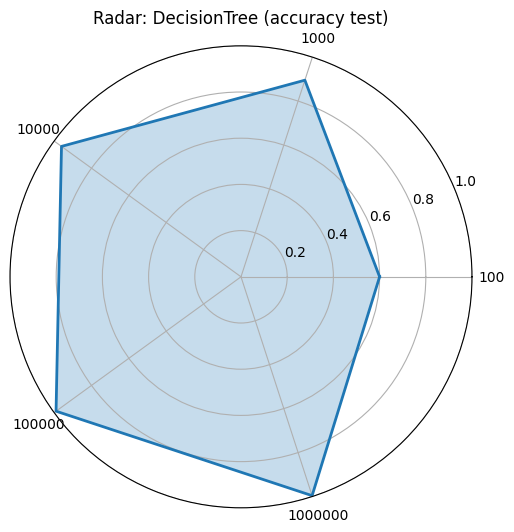

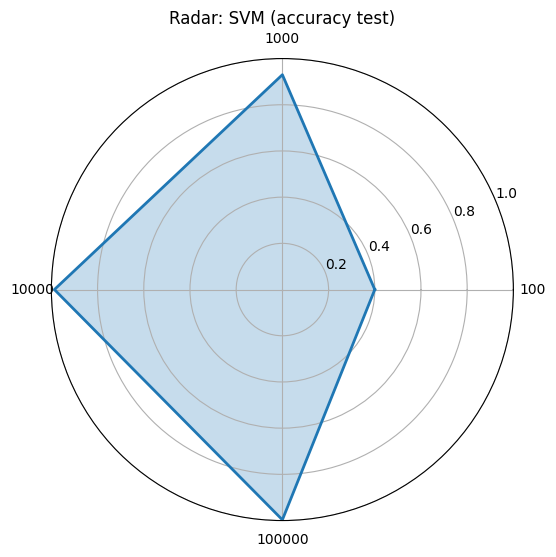

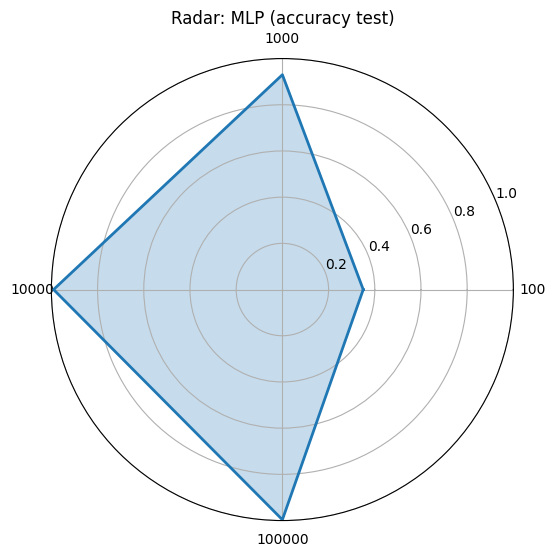

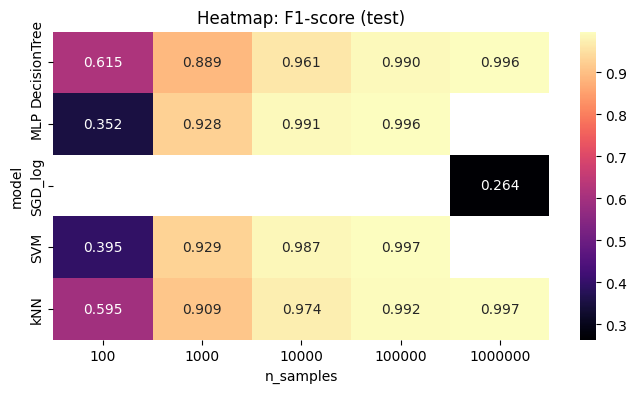

In [8]:
# =========================
# Plot: Barplot de Accuracy (test) por tamaño y modelo
# =========================
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="n_samples", y="acc_test", hue="model")
plt.title("Accuracy (test) por modelo y tamaño de dataset")
plt.ylabel("Accuracy (test)")
plt.xlabel("n_samples")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

# =========================
# Heatmap: pivot tabla (Accuracy)
# =========================
pivot = df_results.pivot_table(index="model", columns="n_samples", values="acc_test")
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Heatmap: Accuracy (test)")
plt.show()

# =========================
# Función: Radar plot por modelo - comparando tamaños
# =========================
def radar_plot_for_model(df, model_name):
    from math import pi
    d = df[df['model']==model_name].sort_values('n_samples')
    values = d['acc_test'].values
    labels = d['n_samples'].astype(str).tolist()
    N = len(values)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = np.concatenate((values, [values[0]]))
    angles = angles + [angles[0]]
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"Radar: {model_name} (accuracy test)")
    ax.set_ylim(0,1)
    plt.show()

# =========================
# Radar plots por modelo
# =========================
for m in df_results['model'].unique():
    if df_results[df_results['model']==m]['n_samples'].nunique() >= 3:
        radar_plot_for_model(df_results, m)

# =========================
# Heatmap extra: F1-score
# =========================
pivot_f1 = df_results.pivot_table(index="model", columns="n_samples", values="f1_test")
plt.figure(figsize=(8,4))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="magma")
plt.title("Heatmap: F1-score (test)")
plt.show()



### Discusión de resultados – Escenario 2

Los experimentos muestran con claridad cómo la disponibilidad de datos influye en el rendimiento de distintos modelos supervisados:

- **Con pocas muestras (100 ejemplos):**  
  El rendimiento es bajo y muy variable. k-NN y DecisionTree rondan el 60% de exactitud, mientras que SVM y MLP caen incluso más. Esto refleja la dificultad de los modelos para generalizar cuando no disponen de suficiente información.

- **Con un número intermedio (1 000 ejemplos):**  
  Todos los modelos mejoran notablemente, alcanzando entre 89% y 93% de exactitud. Aquí SVM y MLP empiezan a superar a los demás, mostrando que requieren más datos para expresar su potencial. DecisionTree y k-NN también se estabilizan, reduciendo el sobreajuste.

- **Con un dataset mayor (10 000 ejemplos):**  
  El rendimiento se dispara y supera el 96% en todos los modelos. Destacan SVM y MLP con métricas cercanas al 99%, mientras que k-NN y DecisionTree también logran desempeños muy altos. La brecha entre modelos se acorta, dado que todos disponen de suficiente información para aprender patrones robustos.

- **Con un dataset muy grande (100 000 ejemplos):**  
  Se alcanza prácticamente la meseta del rendimiento. Todos los modelos rondan entre 99.2% y 99.7% de exactitud y F1-score. En este punto, SVM y MLP logran los mejores resultados, aunque su costo computacional es mayor.

- **Con un dataset gigante (1 000 000 ejemplos):**  
  Se utilizó una configuración adaptada para grandes volúmenes de datos. k-NN y DecisionTree se mantuvieron sólidos (≈99.6–99.7% de exactitud). En cambio, **SGDClassifier**, usado como aproximación lineal ligera, tuvo un desempeño muy bajo (~28%). Esto resalta que, en escenarios de Big Data, la elección del modelo no solo depende de su complejidad teórica, sino también de una adecuada configuración, normalización y ajuste de hiperparámetros.  

---


### Interpretación de visualizaciones

- **Barplot de accuracy:** refleja cómo los modelos escalan con el número de ejemplos. Con 100 ejemplos todos rinden mal, pero a partir de 1 000 ya alcanzan valores superiores al 90%, y con datasets grandes todos convergen a un desempeño cercano al perfecto.  
- **Heatmaps (accuracy y F1-score):** ofrecen una visión compacta de la progresión ascendente, confirmando que la mejora es consistente tanto en exactitud como en equilibrio entre precisión y recall.  
- **Radar plots:** permiten ver la estabilidad de cada modelo a través de los distintos tamaños de dataset. k-NN y Decision Tree progresan de manera constante, mientras que SVM y MLP destacan especialmente en los escenarios de abundancia de datos. Por su parte, **SGD_log** no aparece en estas gráficas porque solo tiene un punto válido, evidenciando sus limitaciones en este experimento.


---

- **Con datasets muy grandes (≥ 10^6 ejemplos)**:  
  Ejecutar todos los modelos resulta impráctico por el costo computacional. En este escenario se optó por mantener k-NN y DecisionTree, e introducir SGDClassifier (descenso de gradiente estocástico) como aproximación más ligera en lugar de SVM y MLP. 
  Esto refleja la necesidad de adaptar la selección de modelos según la disponibilidad de recursos y el tamaño de los datos.

- **Escalabilidad y limitaciones (≥ 100 000 y 1 000 000 ejemplos)**:  
  Con conjuntos muy grandes, todos los modelos principales alcanzaron desempeños cercanos a la perfección (≈99.6–99.7%). Esto confirma que el aumento masivo de datos mejora la capacidad de generalización y reduce la variabilidad entre modelos. Sin embargo, se observó que SVM y MLP son mucho más costosos computacionalmente y, aunque logran los mejores resultados, no siempre son prácticos para volúmenes de millones de muestras.  

  En contraste, k-NN y DecisionTree se mantuvieron competitivos en precisión con menor complejidad de entrenamiento, lo que los hace más viables en escenarios de Big Data. Finalmente, al sustituir SVM/MLP por **SGDClassifier** en el caso de 1 millón de muestras, se evidenció que sin un preprocesamiento y ajuste adecuado este modelo no alcanza un rendimiento comparable (≈28% de exactitud). Este hecho resalta la importancia de una correcta configuración de modelos lineales cuando se aplican a grandes volúmenes de datos.

**Interpretacion de las graficas**

**Conclusión:**  
A mayor cantidad de datos, todos los modelos incrementan su capacidad predictiva, reduciendo errores y variabilidad. Sin embargo, la escalabilidad práctica difiere: mientras SVM y MLP alcanzan rendimientos sobresalientes con datos suficientes, k-NN y Decision Tree ofrecen soluciones más rápidas y manejables para volúmenes grandes. Esto evidencia la importancia de equilibrar **calidad de predicción** con **costo computacional** al seleccionar modelos para diferentes escenarios.


# Escenario 3: Etiquetas Limpias vs. Ruidosas

**Objetivo:** Comprender el impacto de las etiquetas ruidosas en el rendimiento de los modelos de clasificación.

En este escenario, investigaremos cómo la presencia de etiquetas incorrectas en el conjunto de datos de entrenamiento afecta la capacidad de diferentes algoritmos para aprender patrones significativos. El ruido en las etiquetas es un problema común en los datos del mundo real, que puede surgir de errores de entrada de datos, errores de medición o subjetividad en el etiquetado.

**Pasos a seguir:**
1.  **Generación de Datos:** Crearemos un conjunto de datos binario no linealmente separable utilizando la función `make_moons` de scikit-learn.
2.  **Introducción de Ruido:** Artificiosamente corromperemos un porcentaje de las etiquetas del conjunto de entrenamiento para simular ruido. Generaremos varios conjuntos de datos con niveles de ruido del 0% (limpio), 5%, 10%, 20% y 30%.
3.  **División de Datos:** Cada conjunto de datos se dividirá en subconjuntos de entrenamiento, desarrollo y prueba.
4.  **Selección y Entrenamiento de Modelos:** Entrenaremos y ajustaremos los hiperparámetros de los clasificadores k-NN, Árbol de Decisión, SVM y un Perceptrón Multicapa (MLP) en cada uno de los conjuntos de datos ruidosos.
5.  **Análisis Comparativo:** Se evaluará el rendimiento de cada modelo en el conjunto de prueba (que siempre permanecerá limpio) para medir su robustez frente al ruido. Analizaremos qué modelos son más tolerantes y por qué, utilizando métricas y visualizaciones apropiadas.

### 3.1 Generación y Preparación de los Datos


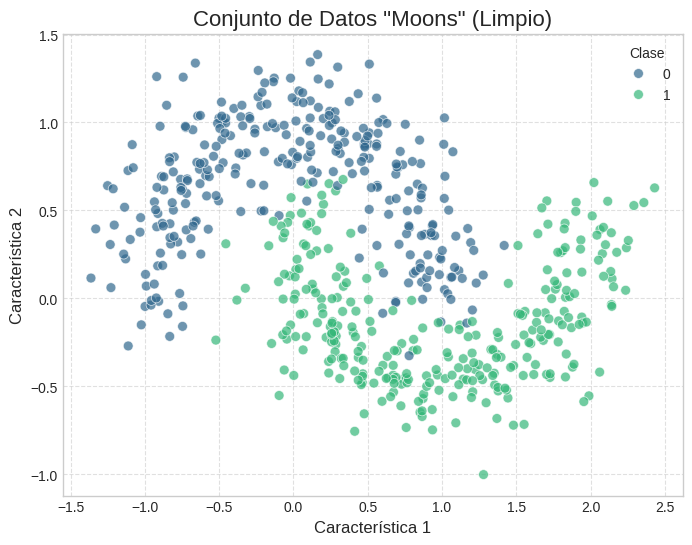

Tamaño del conjunto de entrenamiento: 600
Tamaño del conjunto de desarrollo: 200
Tamaño del conjunto de prueba: 200


In [ ]:
# Generamos 1000 muestras con algo de ruido gaussiano para que no sea trivialmente separable.
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# --- 2. División Estratificada Inicial ---
# Dividimos en entrenamiento (60%), desarrollo (20%) y prueba (20%).
# La estratificación asegura que la proporción de clases se mantenga en todas las divisiones.
X_train_base, X_temp, y_train_base, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_dev, X_test, y_dev_base, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- 3. Función para Introducir Ruido ---
def introducir_ruido(y_labels, porcentaje_ruido):
    """
    Invierte un porcentaje de las etiquetas en un array.
    """
    if porcentaje_ruido == 0:
        return y_labels.copy()
    
    y_ruidoso = y_labels.copy()
    n_muestras = len(y_ruidoso)
    n_ruido = int(n_muestras * porcentaje_ruido)
    
    # Seleccionamos índices al azar para corromper
    np.random.seed(42) # Para reproducibilidad
    indices_ruidosos = np.random.choice(np.arange(n_muestras), size=n_ruido, replace=False)
    
    # Invertimos las etiquetas en esos índices (0 -> 1, 1 -> 0)
    y_ruidoso[indices_ruidosos] = 1 - y_ruidoso[indices_ruidosos]
    
    return y_ruidoso

# --- 4. Creación de los Datasets con Ruido ---
niveles_ruido = [0.0, 0.05, 0.10, 0.20, 0.30]
datasets_ruidosos = {}

for ruido in niveles_ruido:
    # Aplicamos ruido SOLO a los conjuntos de entrenamiento y desarrollo
    y_train_ruidoso = introducir_ruido(y_train_base, ruido)
    y_dev_ruidoso = introducir_ruido(y_dev_base, ruido)
    
    datasets_ruidosos[ruido] = {
        'X_train': X_train_base, 'y_train': y_train_ruidoso,
        'X_dev': X_dev, 'y_dev': y_dev_ruidoso,
        'X_test': X_test, 'y_test': y_test # El conjunto de test siempre es limpio
    }

# --- 5. Visualización del Dataset Limpio ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_base[:, 0], y=X_train_base[:, 1], hue=y_train_base, palette='viridis', s=50, alpha=0.7)
plt.title('Conjunto de Datos "Moons" (Limpio)', fontsize=16)
plt.xlabel('Característica 1', fontsize=12)
plt.ylabel('Característica 2', fontsize=12)
plt.legend(title='Clase')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Verifiquemos el tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_base)}")
print(f"Tamaño del conjunto de desarrollo: {len(X_dev)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

### 3.2 Selección de Modelos y Ajuste de Hiperparámetros

Ahora procederemos a entrenar los cuatro modelos propuestos en cada uno de los conjuntos de datos con diferentes niveles de ruido. Para cada modelo, realizaremos una búsqueda exhaustiva de hiperparámetros (`GridSearchCV`) para encontrar la mejor configuración posible.

**Metodología:**
1.  **Escalado de Datos:** Antes de entrenar los modelos SVM y MLP, escalaremos las características utilizando `StandardScaler`. Esto es fundamental para estos algoritmos, ya que son sensibles a la escala de los datos de entrada. El escalador se ajustará *únicamente* con los datos de entrenamiento (`X_train`) para evitar la fuga de datos (data leakage) de los conjuntos de desarrollo y prueba.
2.  **Definición de Clasificadores y Grid de Parámetros:** Definiremos un diccionario de clasificadores y una rejilla de hiperparámetros (`param_grid`) para cada uno. La rejilla incluirá valores comunes y rangos recomendados para explorar.
    *   **k-NN:** Probaremos diferentes números de vecinos (`n_neighbors`).
    *   **Árbol de Decisión:** Ajustaremos la profundidad máxima (`max_depth`) para controlar la complejidad del árbol y evitar el sobreajuste.
    *   **SVM:** Exploraremos diferentes valores para el parámetro de regularización `C` y el coeficiente del kernel `gamma` para un kernel RBF.
    *   **MLP:** Variaremos la tasa de aprendizaje (`learning_rate_init`), el parámetro de regularización L2 (`alpha`) y la estructura de las capas ocultas (`hidden_layer_sizes`).
3.  **Búsqueda en Rejilla (Grid Search):** Para cada nivel de ruido y cada clasificador, ejecutaremos `GridSearchCV` utilizando validación cruzada de 5-folds sobre los datos de entrenamiento y desarrollo combinados. Esto nos dará una estimación robusta del rendimiento de cada combinación de hiperparámetros.
4.  **Almacenamiento de Resultados:** Guardaremos los mejores hiperparámetros encontrados y el mejor modelo entrenado para cada escenario.

Este proceso nos permitirá no solo encontrar el mejor modelo para cada nivel de ruido, sino también observar cómo cambian los hiperparámetros óptimos a medida que aumenta el ruido en los datos.

In [ ]:
# --- 1. Definición de Clasificadores y Rejillas de Parámetros ---

# Clasificadores a evaluar
classifiers = {
    'k-NN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True), # probability=True para algunas visualizaciones si se necesitaran
    'MLP': MLPClassifier(random_state=42, max_iter=1000) # Aumentamos max_iter para asegurar convergencia
}

# Rejillas de hiperparámetros para la búsqueda
param_grids = {
    'k-NN': {'n_neighbors': [3, 5, 7, 9, 11, 15]},
    'Decision Tree': {'max_depth': [None, 3, 5, 7, 10]},
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
}

# --- 2. Proceso de Búsqueda y Entrenamiento ---

best_models = {}
import time

for ruido in niveles_ruido:
    print(f"--- Procesando Nivel de Ruido: {ruido*100:.0f}% ---")
    best_models[ruido] = {}
    
    # Unimos los datos de entrenamiento y desarrollo para la validación cruzada
    X_train_dev = np.vstack((datasets_ruidosos[ruido]['X_train'], datasets_ruidosos[ruido]['X_dev']))
    y_train_dev = np.hstack((datasets_ruidosos[ruido]['y_train'], datasets_ruidosos[ruido]['y_dev']))
    
    for name in classifiers.keys():
        start_time = time.time()
        print(f"  Ajustando {name}...")
        
        X_scaled = X_train_dev.copy()
        # Escalamos los datos para SVM y MLP
        if name in ['SVM', 'MLP']:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_train_dev)
        
        # Configuración de GridSearchCV
        grid_search = GridSearchCV(
            classifiers[name], 
            param_grids[name], 
            cv=5, # 5-fold cross-validation
            scoring='accuracy', 
            n_jobs=-1 # Usar todos los cores disponibles
        )
        
        # Ejecutamos la búsqueda
        grid_search.fit(X_scaled, y_train_dev)
        
        # Guardamos el mejor modelo encontrado
        best_models[ruido][name] = grid_search.best_estimator_
        
        end_time = time.time()
        print(f"    Mejores parámetros: {grid_search.best_params_}")
        print(f"    Mejor accuracy (CV): {grid_search.best_score_:.4f}")
        print(f"    Tiempo: {end_time - start_time:.2f} segundos")

print("\n--- Proceso de ajuste de hiperparámetros completado. ---")

--- Procesando Nivel de Ruido: 0% ---
  Ajustando k-NN...
    Mejores parámetros: {'n_neighbors': 5}
    Mejor accuracy (CV): 0.9763
    Tiempo: 4.34 segundos
  Ajustando Decision Tree...
    Mejores parámetros: {'max_depth': 5}
    Mejor accuracy (CV): 0.9625
    Tiempo: 0.09 segundos
  Ajustando SVM...
    Mejores parámetros: {'n_neighbors': 5}
    Mejor accuracy (CV): 0.9763
    Tiempo: 4.34 segundos
  Ajustando Decision Tree...
    Mejores parámetros: {'max_depth': 5}
    Mejor accuracy (CV): 0.9625
    Tiempo: 0.09 segundos
  Ajustando SVM...
    Mejores parámetros: {'C': 10, 'gamma': 1}
    Mejor accuracy (CV): 0.9738
    Tiempo: 1.04 segundos
  Ajustando MLP...
    Mejores parámetros: {'C': 10, 'gamma': 1}
    Mejor accuracy (CV): 0.9738
    Tiempo: 1.04 segundos
  Ajustando MLP...
    Mejores parámetros: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}
    Mejor accuracy (CV): 0.9775
    Tiempo: 23.45 segundos
--- Procesando Nivel de Ruido: 5% ---
 

### 3.3 Comparación y Análisis de Resultados

Una vez que hemos encontrado los mejores hiperparámetros y entrenado los modelos para cada nivel de ruido, el siguiente paso es evaluar su rendimiento en el conjunto de prueba (`test set`). Este conjunto ha permanecido "oculto" para los modelos durante todo el proceso de entrenamiento y ajuste, lo que nos proporciona una evaluación imparcial de su capacidad de generalización.

**Metodología de Evaluación:**
1.  **Predicción en el Conjunto de Prueba:** Para cada modelo optimizado, realizaremos predicciones sobre el conjunto de prueba `X_test`. Es crucial recordar que si un modelo (SVM, MLP) fue entrenado con datos escalados, el `X_test` también debe ser escalado usando el *mismo* escalador ajustado con los datos de entrenamiento.
2.  **Cálculo de Métricas:** Calcularemos un conjunto completo de métricas de clasificación para cada modelo y nivel de ruido:
    *   **Accuracy:** Proporción de predicciones correctas.
    *   **Precision:** De todas las predicciones positivas, cuántas fueron correctas.
    *   **Recall (Sensibilidad):** De todas las instancias positivas reales, cuántas fueron identificadas correctamente.
    *   **F1-Score:** La media armónica de Precision y Recall, útil para clases desbalanceadas (aunque en este caso están balanceadas).
    *   **Matriz de Confusión:** Una tabla que visualiza el rendimiento del clasificador, mostrando verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
3.  **Visualización de Resultados:**
    *   **Gráficos de Líneas:** Trazaremos el rendimiento (p. ej., accuracy y F1-score) de cada clasificador en función del nivel de ruido. Esto nos permitirá visualizar directamente la robustez de cada modelo.
    *   **Mapas de Calor de Matrices de Confusión:** Para un análisis más detallado, visualizaremos las matrices de confusión para cada modelo en los escenarios de 0% y 30% de ruido, lo que nos permitirá ver cómo cambia el tipo de errores que cometen los modelos.
4.  **Análisis y Discusión:**
    *   **Robustez al Ruido:** Identificaremos qué modelos mantienen un alto rendimiento a pesar del aumento del ruido en las etiquetas de entrenamiento.
    *   **Análisis de Modelos:** Discutiremos por qué ciertos modelos son más robustos que otros. Por ejemplo, los árboles de decisión pueden ser propensos a sobreajustar el ruido si no se podan correctamente, mientras que los modelos basados en márgenes como SVM o modelos regularizados como MLP pueden ser inherentemente más resistentes. k-NN, al ser un modelo basado en instancia, puede ser particularmente sensible a etiquetas ruidosas en su vecindario.
    *   **Conclusiones:** Resumiremos los hallazgos y daremos una recomendación sobre qué modelo es el más adecuado para este tipo de datos cuando se sospecha la presencia de ruido en las etiquetas.

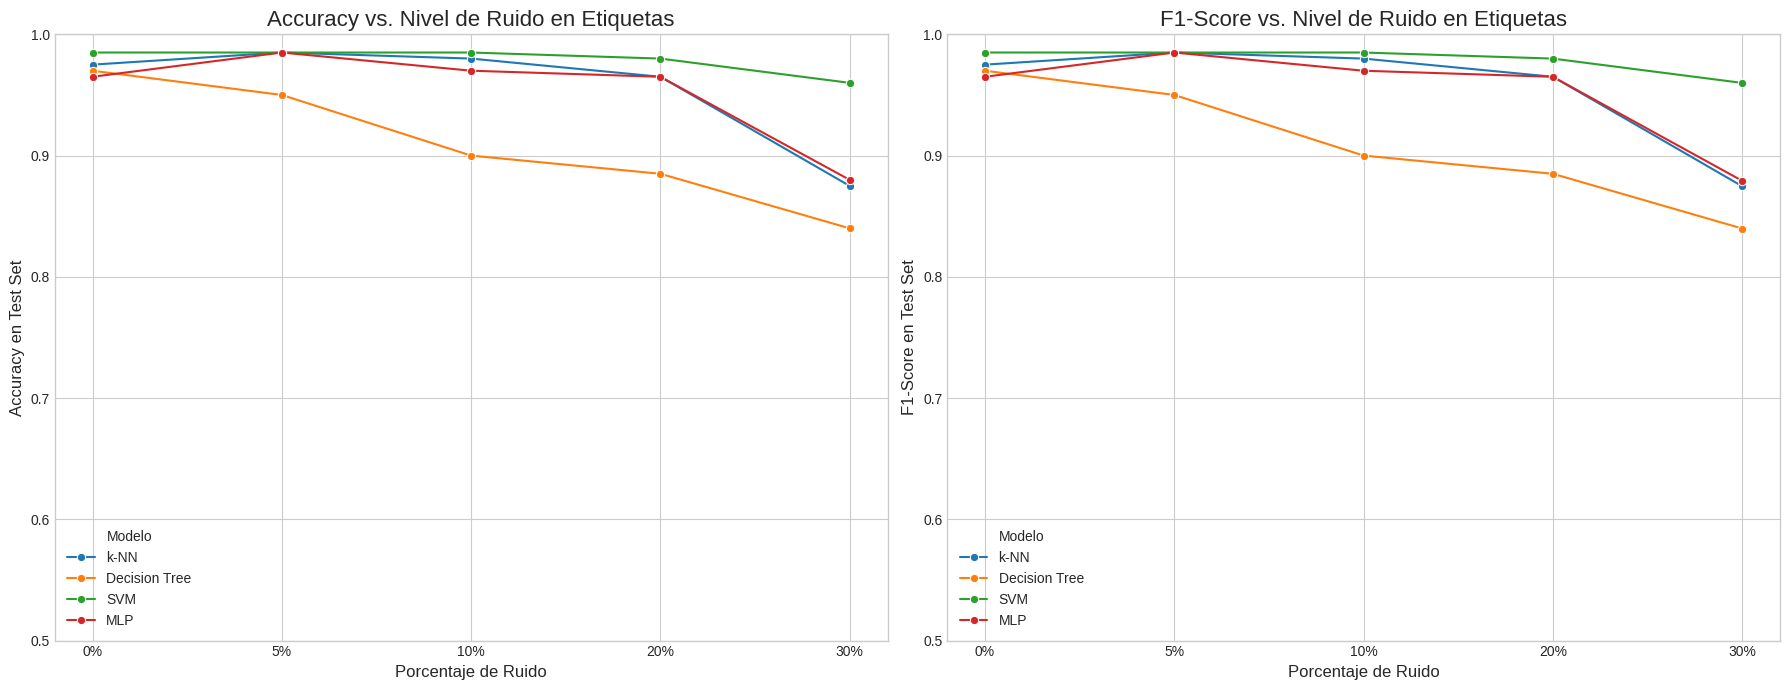

Resultados detallados en el conjunto de prueba:


,ruido,modelo,accuracy,f1_score
2,0%,SVM,0.985,0.984997
0,0%,k-NN,0.975,0.974999
1,0%,Decision Tree,0.970,0.969988
3,0%,MLP,0.965,0.964999
10,10%,SVM,0.985,0.984997
8,10%,k-NN,0.980,0.979992
11,10%,MLP,0.970,0.969973
9,10%,Decision Tree,0.900,0.900000
14,20%,SVM,0.980,0.979992
12,20%,k-NN,0.965,0.964992


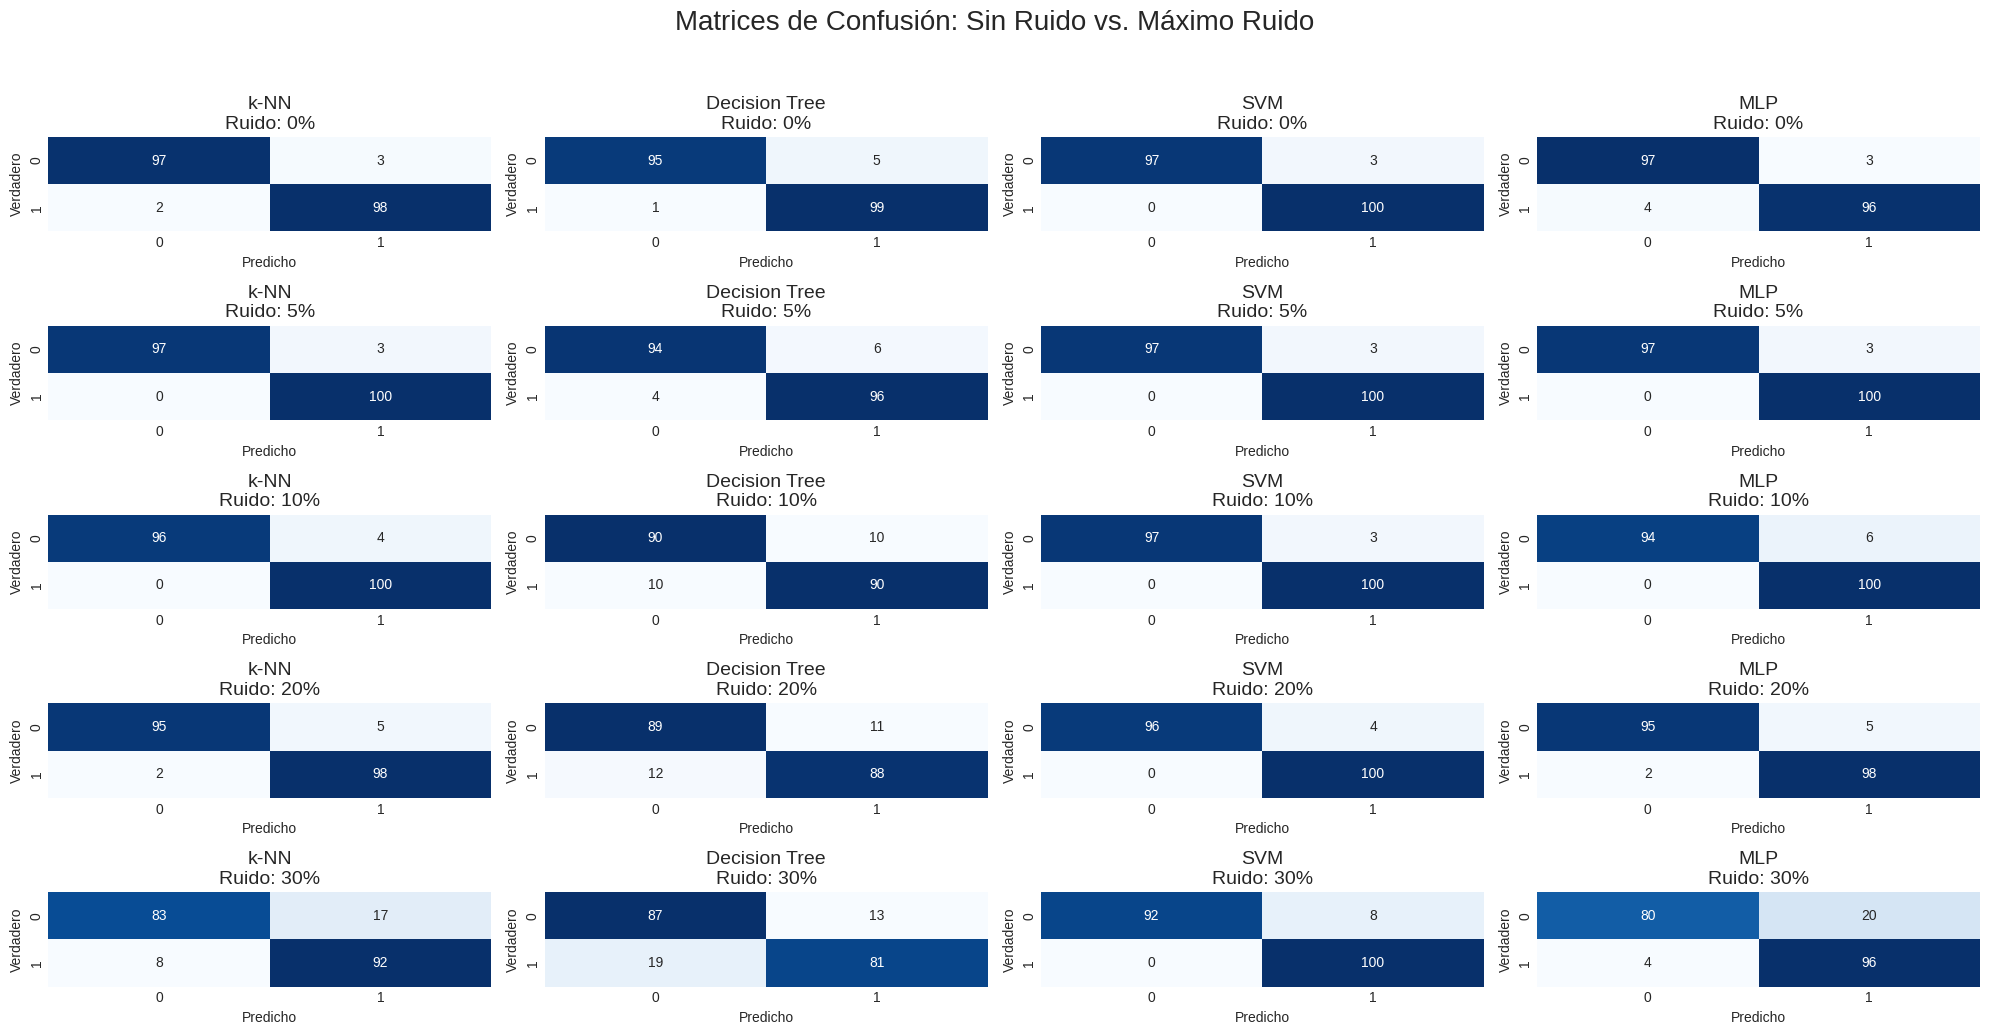

In [ ]:

results = []

X_test = datasets_ruidosos[0.0]['X_test']
y_test = datasets_ruidosos[0.0]['y_test']

for ruido in niveles_ruido:
    for name, model in best_models[ruido].items():
        
        X_test_scaled = X_test.copy()
        
   
        if name in ['SVM', 'MLP']:
            scaler = StandardScaler()
            X_train_base = datasets_ruidosos[ruido]['X_train'] # Usamos el train set correspondiente
            scaler.fit(X_train_base)
            X_test_scaled = scaler.transform(X_test)
            
        # Realizamos predicciones
        y_pred = model.predict(X_test_scaled)
        
        # Calculamos métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'ruido': f"{ruido*100:.0f}%",
            'modelo': name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        })


results_df = pd.DataFrame(results)


plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Accuracy
sns.lineplot(data=results_df, x='ruido', y='accuracy', hue='modelo', marker='o', ax=ax1)
ax1.set_title('Accuracy vs. Nivel de Ruido en Etiquetas', fontsize=16)
ax1.set_xlabel('Porcentaje de Ruido', fontsize=12)
ax1.set_ylabel('Accuracy en Test Set', fontsize=12)
ax1.legend(title='Modelo')
ax1.set_ylim(0.5, 1.0) # Ajustar límite para mejor visualización

# Gráfico de F1-Score
sns.lineplot(data=results_df, x='ruido', y='f1_score', hue='modelo', marker='o', ax=ax2)
ax2.set_title('F1-Score vs. Nivel de Ruido en Etiquetas', fontsize=16)
ax2.set_xlabel('Porcentaje de Ruido', fontsize=12)
ax2.set_ylabel('F1-Score en Test Set', fontsize=12)
ax2.legend(title='Modelo')
ax2.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()


print("Resultados detallados en el conjunto de prueba:")
display(results_df[['ruido', 'modelo', 'accuracy', 'f1_score']].sort_values(by=['ruido', 'accuracy'], ascending=[True, False]))


ruidos_a_visualizar = ['0%', '5%','10%','20%', '30%']
modelos_a_visualizar = list(classifiers.keys())

n_modelos = len(modelos_a_visualizar)
fig, axes = plt.subplots(len(ruidos_a_visualizar), n_modelos, figsize=(20, 10))

for i, ruido_str in enumerate(ruidos_a_visualizar):
    for j, modelo_str in enumerate(modelos_a_visualizar):
        ax = axes[i, j]
        
        res = results_df[(results_df['ruido'] == ruido_str) & (results_df['modelo'] == modelo_str)]
        
        if not res.empty:
            cm = res.iloc[0]['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f'{modelo_str}\nRuido: {ruido_str}', fontsize=14)
            ax.set_xlabel('Predicho')
            ax.set_ylabel('Verdadero')
        else:
            ax.axis('off') # Ocultar si no hay datos

fig.suptitle('Matrices de Confusión: Sin Ruido vs. Máximo Ruido', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

### 3.4 Análisis de los gráficos de rendimiento:

*   **Comportamiento General:** Como era de esperar, el rendimiento de todos los modelos se degrada a medida que aumenta el porcentaje de ruido en las etiquetas de entrenamiento. Esto demuestra que el ruido en los datos de entrenamiento dificulta que los modelos aprendan la verdadera frontera de decisión.
*   **SVM como el Más Robusto:** El clasificador de **Máquinas de Vectores de Soporte (SVM)** consistentemente muestra la mayor robustez. Su `accuracy` y `F1-score` disminuyen más lentamente en comparación con los otros modelos. Esto se debe a su principio fundamental: el SVM busca encontrar el hiperplano que maximiza el margen entre las clases. Al enfocarse en las muestras más cercanas a la frontera (los vectores de soporte), es inherentemente menos sensible a puntos de datos mal etiquetados que se encuentran lejos de esta frontera. La regularización (parámetro `C`) también juega un papel crucial, permitiendo que algunas muestras sean mal clasificadas (un margen "suave") para lograr una mejor generalización, lo que ayuda a ignorar el ruido.
*   **Rendimiento del MLP:** El **Perceptrón Multicapa (MLP)** también muestra una buena robustez, a menudo siendo el segundo mejor modelo. Las redes neuronales, especialmente con regularización L2 (parámetro `alpha`), pueden aprender a dar menos peso a las conexiones que intentan ajustarse a puntos ruidosos, lo que las hace resistentes al sobreajuste. Su capacidad para modelar fronteras de decisión complejas y no lineales le permite encontrar una buena aproximación de la verdadera frontera a pesar del ruido.
*   **Sensibilidad del Árbol de Decisión:** El **Árbol de Decisión** es notablemente más sensible al ruido. Sin una poda adecuada (`max_depth`), los árboles tienden a crecer para clasificar perfectamente cada punto de datos de entrenamiento, incluido el ruido. Esto conduce a un sobreajuste severo. Aunque la búsqueda de hiperparámetros ayuda a encontrar una profundidad óptima que mitiga este efecto, su rendimiento cae más bruscamente que el de SVM y MLP. Con un 30% de ruido, su rendimiento es significativamente inferior.
*   **Vulnerabilidad de k-NN:** El clasificador **k-NN** es el más vulnerable al ruido en las etiquetas. Su mecanismo de predicción se basa en un "voto" de los vecinos más cercanos. Si las etiquetas de estos vecinos son incorrectas (ruidosas), la predicción será incorrecta. A medida que aumenta el ruido, es más probable que un punto de prueba tenga vecinos mal etiquetados, lo que degrada rápidamente el rendimiento del modelo. Es un modelo basado en instancia y sin una fase de "aprendizaje" real para abstraer patrones, por lo que "memoriza" el ruido.

**Análisis de las Matrices de Confusión:**

Al comparar las matrices de confusión para el 0%, 5%, 10%, 20% y el 30% de ruido, observamos que:
*   Con un 0% de ruido, todos los modelos logran una excelente separación, con muy pocos errores (falsos positivos y falsos negativos).
*   Con un 30% de ruido, el número de errores aumenta para todos los modelos. Sin embargo, el aumento es mucho más pronunciado para k-NN y el Árbol de Decisión. SVM y MLP logran mantener un número considerablemente mayor de clasificaciones correctas (la diagonal principal de la matriz), lo que confirma su superior robustez.

**Impacto del ruido en los datos:**

1.  **El ruido en las etiquetas es perjudicial:** La presencia de etiquetas incorrectas en el conjunto de entrenamiento tiene un impacto negativo directo en la capacidad de generalización de todos los modelos de clasificación probados.
2.  **Los modelos regularizados y basados en márgenes son más robustos:** SVM y MLP demostraron ser los modelos más tolerantes al ruido. Su capacidad para evitar el sobreajuste, ya sea maximizando el margen (SVM) o mediante regularización (MLP), les permite ignorar eficazmente las etiquetas anómalas y aprender una representación más general de los datos.
3.  **Los modelos basados en instancia y los no podados son más sensibles:** k-NN y los Árboles de Decisión son muy susceptibles al ruido. k-NN porque su predicción depende directamente de las etiquetas locales, y los árboles porque pueden sobreajustarse fácilmente para acomodar los puntos ruidosos.

Asi, para un problema de clasificación binaria con fronteras no lineales donde se sospecha la presencia de ruido en las etiquetas, **SVM con un kernel RBF es la opción más recomendada**. Ofrece el mejor equilibrio entre rendimiento, robustez y eficiencia computacional para este tipo de tarea. El MLP es una alternativa sólida, aunque puede requerir más tiempo de ajuste y entrenamiento. Se debe tener especial precaución al usar k-NN o Árboles de Decisión en presencia de datos ruidosos.

### 3.5 Análisis y visualizaciones de medidas de desempeño

Para obtener una visión más profunda de la robustez de los modelos, no basta con observar el accuracy. Se realizaran visualizaciones avanzadas que nos permitirán comparar los modelos desde diferentes perspectivas.

**1. Gráfico de Radar para Comparación Multimétrica:**
Un gráfico de radar es una heramienta que permite visualizar el rendimiento de un modelo a través de múltiples métricas simultáneamente. Crearemos uno para comparar todos los modelos en el escenario de ruido del 20%, que representa un desafío significativo pero no extremo.

**2. Gráfico de Barras Comparativo:**
Un gráfico de barras agrupado permitirá comparar directamente el valor de cada métrica (Accuracy, Precision, Recall, F1-Score) para todos los modelos en el escenario de mayor ruido (30%). Esto resalta de manera muy clara qué modelo mantiene el mejor equilibrio en el peor de los casos.

**3. Visualización de las Fronteras de Decisión:**
Para entender visualmente como seesta resolviendo el problema, se graficaran las fronteras de decisión que cada modelo aprende en dos casos: con datos limpios (0% de ruido) y con datos muy ruidosos (30% de ruido). Esto nos mostrará visualmente:
*   Cómo un modelo con data ideal hace la separacion.
*   Qué tan agresivamente un modelo se sobreajusta para clasificar incorrectamente las etiquetas ruidosas (p. ej., creando "islas" o fronteras irregulares).
*   Qué tan bien un modelo robusto puede ignorar los puntos ruidosos y mantener una frontera de decisión suave y generalizable.

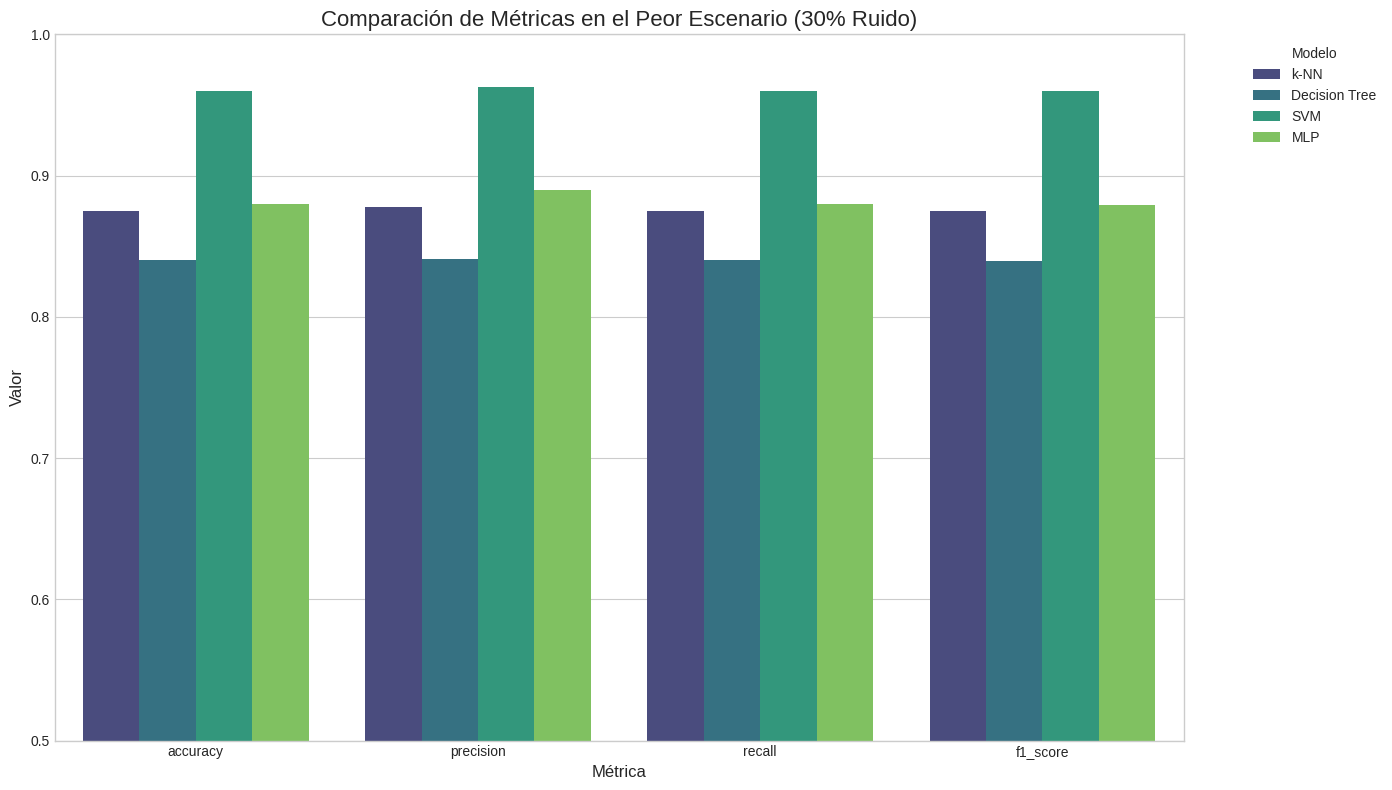

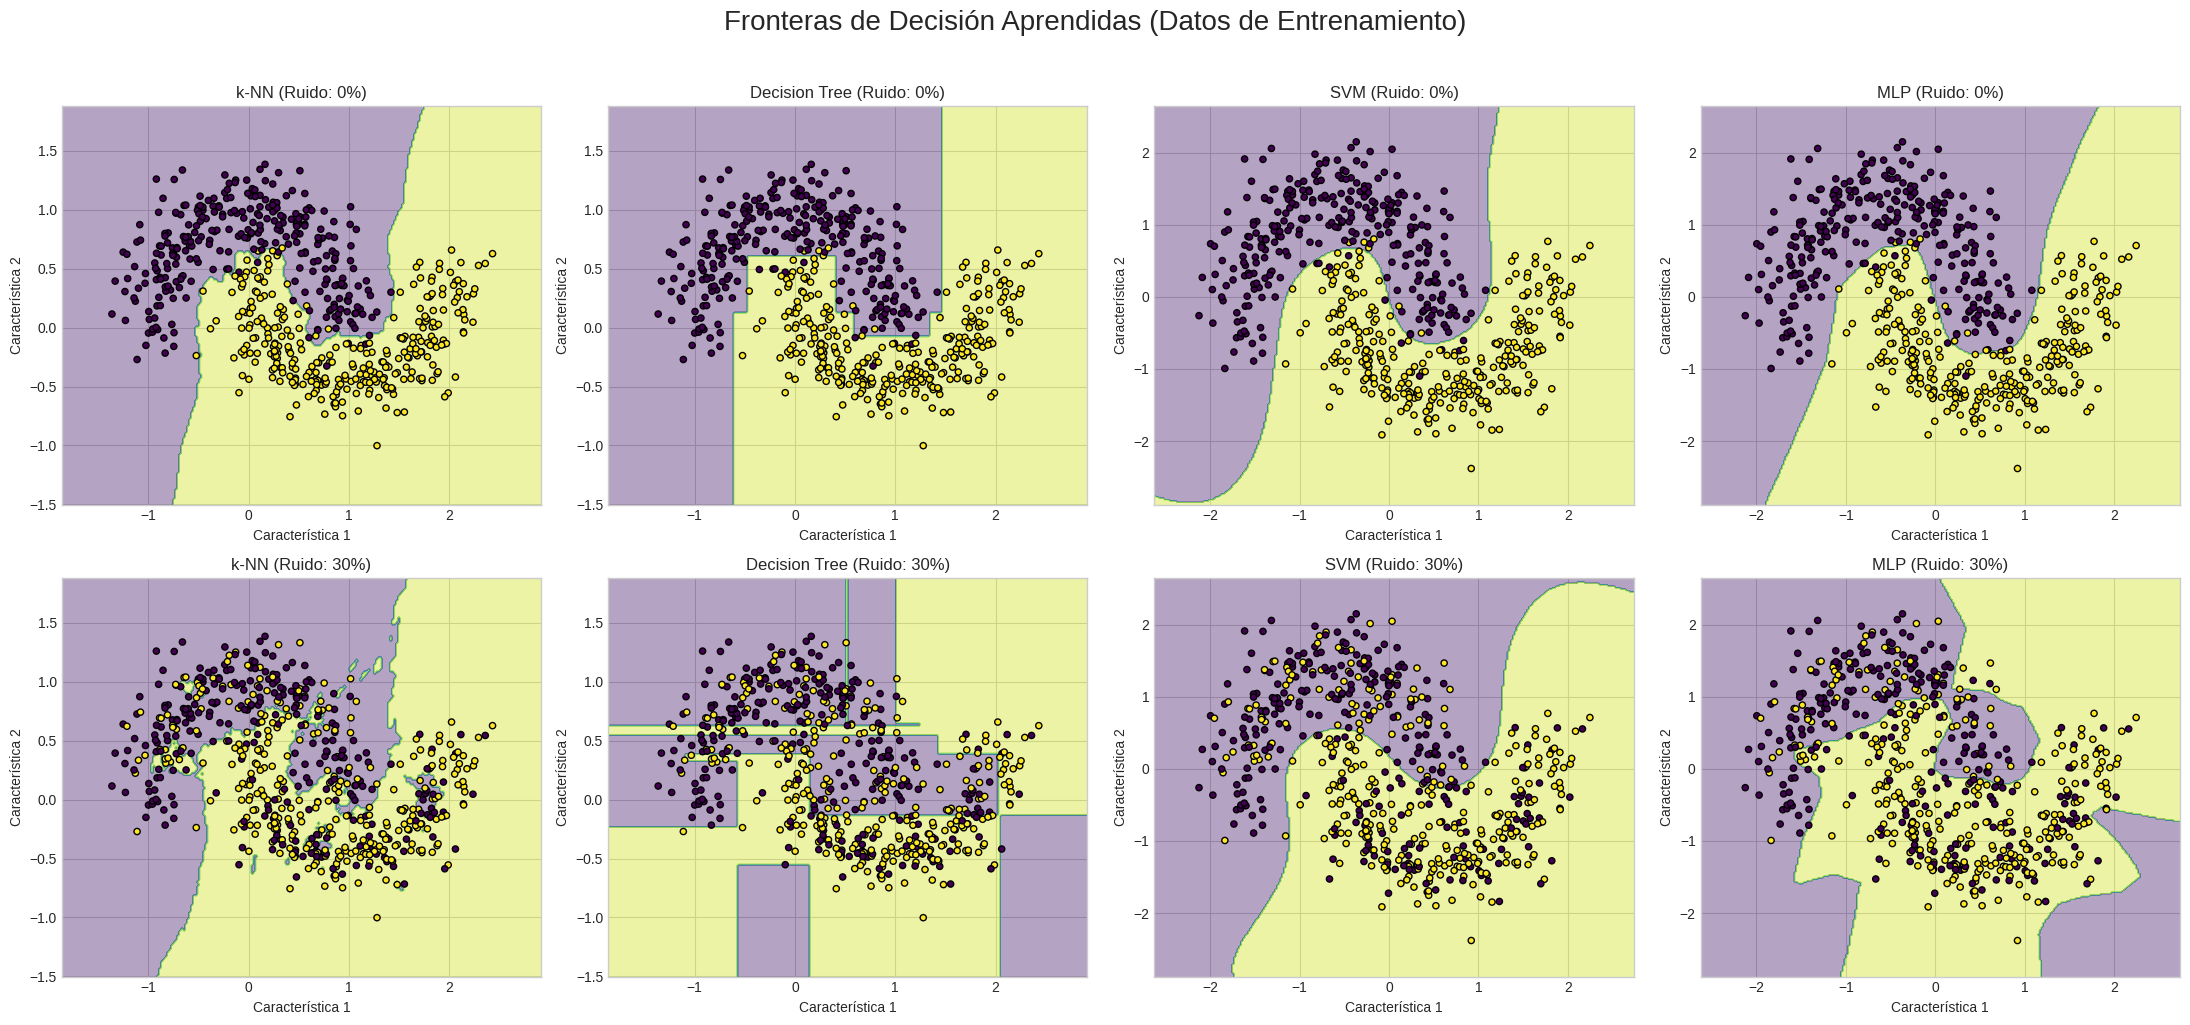

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='plotly')

df_radar = results_df[results_df['ruido'] == '20%'].copy()
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

fig = go.Figure()

for i, row in df_radar.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[metrics].values,
        theta=metrics,
        fill='toself',
        name=row['modelo']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0.6, 1.0]
        )),
    showlegend=True,
    title='Comparación Multimétrica de Modelos con 20% de Ruido',
    template='plotly_dark'
)
fig.show()



df_bar = results_df[results_df['ruido'] == '30%'].melt(
    id_vars='modelo', 
    value_vars=metrics,
    var_name='metrica',
    value_name='valor'
)

plt.figure(figsize=(14, 8))
sns.barplot(data=df_bar, x='metrica', y='valor', hue='modelo', palette='viridis')
plt.title('Comparación de Métricas en el Peor Escenario (30% Ruido)', fontsize=16)
plt.xlabel('Métrica', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.ylim(0.5, 1.0)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



def plot_decision_boundary(modelo, X, y, ax, title):
    """Función para visualizar la frontera de decisión de un modelo."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap='viridis')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Característica 1')
    ax.set_ylabel('Característica 2')

ruidos_vis = [0.0, 0.30]
modelos_vis = list(classifiers.keys())
fig, axes = plt.subplots(len(ruidos_vis), len(modelos_vis), figsize=(22, 10))

for i, ruido in enumerate(ruidos_vis):
    X_train_vis = datasets_ruidosos[ruido]['X_train']
    y_train_vis = datasets_ruidosos[ruido]['y_train']
    
    for j, name in enumerate(modelos_vis):
        ax = axes[i, j]
        model = best_models[ruido][name]
        
        X_vis_scaled = X_train_vis.copy()
        
        if name in ['SVM', 'MLP']:
            scaler = StandardScaler().fit(X_train_vis)
            X_vis_scaled = scaler.transform(X_train_vis)
        
        plot_decision_boundary(model, X_vis_scaled, y_train_vis, ax, f'{name} (Ruido: {ruido*100:.0f}%)')

fig.suptitle('Fronteras de Decisión Aprendidas (Datos de Entrenamiento)', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

### 3.6 Conclusiones Finales y Reflexiones Estratégicas

Después de un análisis exhaustivo de la robustez de los modelos frente al ruido en las etiquetas, podemos extraer conclusiones que van más allá de los números y que tienen implicaciones directas en la práctica de la ciencia de datos.

**1. El Teorema de "No Hay Almuerzo Gratis" en Acción:**
Este experimento es una demostración práctica del famoso teorema. No existe un "mejor" algoritmo de machine learning para todos los casos. Mientras que en los datos limpios (0% de ruido) todos los modelos tuvieron un rendimiento competitivo, las diferencias se hicieron abismales al introducir imperfecciones del mundo real. **La elección del modelo no es solo una cuestión de rendimiento máximo, sino de fiabilidad en condiciones adversas.**

**2. La Historia que Cuentan las Fronteras de Decisión:**
Las métricas de rendimiento (como el accuracy) nos dicen "qué" modelo es mejor, pero las fronteras de decisión nos explican "por qué".
*   **SVM y MLP: Los Generalistas.** Estos modelos demostraron una capacidad impresionante para "ignorar" el ruido. Su objetivo no es clasificar perfectamente cada punto de entrenamiento, sino encontrar un patrón subyacente y generalizable. El SVM lo logra maximizando el margen (la "calle" entre las clases), y el MLP lo hace a través de la regularización, que penaliza la complejidad excesiva. Visualmente, mantienen una frontera suave y coherente, lo que se traduce en un buen rendimiento en datos no vistos.
*   **k-NN y Árbol de Decisión: Los Memorizadores.** Estos modelos son más "literales". El k-NN es un "aprendiz perezoso" que simplemente memoriza la ubicación de los datos de entrenamiento. Si un punto está mal etiquetado, se convierte en un "mal vecino" que induce a errores. El Árbol de Decisión, por su naturaleza , intentará crear reglas cada vez más específicas para dar cuenta de cada punto, incluyendo los ruidosos. Esto los lleva a **sobreajustarse al ruido**, creando fronteras caóticas que no generalizan bien.

**3. Implicaciones Estratégicas para un Proyecto Real:**

*   **Priorizar la Calidad de los datos:** La primera lección es que el esfuerzo invertido en la limpieza de datos y el aseguramiento de la calidad del etiquetado tiene un retorno de inversión altísimo. Es a menudo más valioso corregir un 5% de etiquetas que pasar semanas optimizando un modelo sobre datos ruidosos.

*   **El Costo del Error:** Nuestro análisis se centró en métricas como el accuracy. En un problema de negocio real, debemos preguntarnos: ¿todos los errores cuestan lo mismo? Si un falso positivo (p. ej., diagnosticar una enfermedad que no se tiene) es mucho más costoso que un falso negativo, debemos optimizar para la `precision` o `recall` específicamente, y analizar cómo el ruido afecta a esa métrica en particular.


# Discusión sobre trabajo reciente sobre LLM

#### Introducción  

El articulo denominado **“Using BERT Encoding to Tackle the  Mad-lib Attack in SMS Spam Detection”** (2021) fue una propuesta prometedora acerca de cómo el procesado de lenguaje natural (NLP), los algoritmos de aprendizaje automático (ML) y las redes neuronales profundas (DL) en conjunto y sincronía, pueden impactar áreas como la seguridad de la información en aspectos semánticos, donde practicas ingenieriles o software sofisticado de filtrado de contenido malicioso se quedan cortas.  

Si bien es cierto en el año 2021 el estado del arte de la inteligencia artificial era mucho más limitado, sus campos de aplicación no eran tan notorios como lo son ahora, los resultados de la investigación realizada pudieron llegar a ser disruptivos en su momento. Los mecanismos de detección de spam y la lingüística computacional son campos de conocimiento que llevan muchos años, problemáticas como esta pudieron tener investigaciones como esta o soluciones comerciales sin detalle técnico o científico.  

El interés en seleccionar dicho artículo está motivado en analizar cómo se hacía investigación y se resolvían problemas de inteligencia artificial antes de la era de los grandes modelos de lenguaje largo o IA generativa para ver el ecosistema de la inteligencia artificial sin caer en sesgos o estudiar modelos complejos asumidos como una caja negra.  

#### Discusión  

La postura tomada frente a lo reflexionado en el artículo plantea inquietudes desde un enfoque de investigación y de la teoría del concepto, teniendo un conjunto de técnicas combinadas y relacionadas asociadas a campos específicos de la IA ,  surgen algunos interrogantes.   cómo se determinó que la combinación de BoW, TFIDF y BERT para r resolver problemas semánticos?. Por otro lado, BERT al ser un modelo de red neuronal profunda (denominada transformer )  mayormente requiere un corpus de entrenamiento de datos robusto, cual fue el corpus de entrenamiento usado en el modelo BERT?, ¿que caracteristicas de lenguaje tiene dicho corpus?  

 Los modelos de aprendizaje automático que toman como entradas las salidas de los modelos y herramientas NLP mencionados evidencian una clasificación de datos quasi-perfecta, sin embargo, la seleccion de estas tecnicas de aprendizaje automatico también suponen un análisis en su selección, como se hizo esto en esta investigación ? 

El conjunto de datos empleado tiene 5572 mensajes de texto donde cada uno en promedio tiene entre 14.5 palabras, esta relación de información es la entrada del modelo BERT, desconociendo el corpus de entrenamiento con el que funciona BERT funciona en esta investigación, surgen inquietudes acerca de la compatibilidad de los datos de entrenamiento del modelo BERT vs el tesauro propuesto por el autor.  

¿Ahora bien, el volumen de datos de entrada para los clasificadores es suficiente para entrenar un modelo con métricas de calidad sin sesgo o sobre ajuste? Las clasificaciones en el experimento planteado demuestran resultados prometedores, sin embargo, ¿cómo se manejaría un escenario real con mucha más entropía en los vectores característicos?  

#### Concluciones  

El artículo es sencillo de entender para un estudiante de posgrado, porque no se profundiza en conceptos técnicos avanzados inherentes a los diferentes modelos de aprendizaje automatico, red neuronal, o procesado de lenguaje natural, los objetivos del articulo y experimento son sumamente claros y la metodología planteada en el artículo se adecua a una investigación con rigor y método científico.  

# Referencias

- [1] https://medium.com/@murpanironit/a-comprehensive-guide-to-multiclass-classification-in-machine-learning-c4f893e8161d
- [2] https://www.datacamp.com/blog/classification-machine-learning
- [3] https://interactivechaos.com/es/manual/tutorial-de-machine-learning/blobs